In [109]:
import ast
import glob
import json
import joblib
import lightgbm as lgb
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import time
import os
import pickle
from collections import Counter
from concurrent.futures import ProcessPoolExecutor
from datetime import datetime
from functools import partial
from imblearn.over_sampling import SMOTE, ADASYN
from itertools import product
from joblib import Parallel, delayed, parallel_backend
from pathlib import Path
from pandas.plotting import scatter_matrix
from prettytable import PrettyTable
from rapidfuzz import fuzz, process
from scipy.stats import mannwhitneyu, ttest_ind
from seaborn import pairplot
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    f1_score,
    fbeta_score,
    precision_score,
    recall_score,
    roc_auc_score
)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from tqdm import tqdm
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from joblib import load

## Spotify data

This dataset, sourced from [Kaggle](https://www.kaggle.com/datasets/bwandowando/spotify-songs-with-attributes-and-lyrics/data), contains information about **955,320** songs on Spotify. It combines **audio attributes**, **metadata**, and **song lyrics**, making it ideal for projects like music recommendation systems, lyric analysis, and mood classification.

| Column | Type | Description |
|:---|:---|:---|
| `id` | _object_ | Spotify's unique identifier for each song.  |
| `name` | _object_ | Title of the song. |
| `album_name` | _object_ | Name of the album the song belongs to (may be missing for some entries). |
| `artists` | _object_ | List of artists associated with the song. |
| `danceability` | _float64_ | Measure (0.0–1.0) of how suitable a track is for dancing, based on tempo, rhythm stability, beat strength, etc. Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.|
| `energy` | _float64_ | Measure (0.0–1.0) of intensity and activity — higher for energetic songs.  Represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low. Features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. Scale from 0.0 to 1.0.|
| `key` | _object_ | Estimated overall musical key (0 = C, 1 = C♯/D♭, ..., 11 = B). |
| `loudness` | _float64_ | Overall loudness of a track in decibels (dB); typically negative values. |
| `mode` | _object_ | Modality of the track: 1 = major, 0 = minor. |
| `speechiness` | _float64_ | Measure (0.0–1.0) of how much spoken words are present in a track. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, including rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. |
| `acousticness` | _float64_ | Measure (0.0–1.0) of whether a track is acoustic. Acousticness refers to how likely a track contains primarily acoustic sounds (as opposed to electric or electronic sounds). It measures whether the sound was likely produced by acoustic instruments like acoustic guitars, pianos, orchestral instruments, or unplugged performances rather than electronically generated or heavily processed sounds.  |
| `instrumentalness` | _float64_ | Prediction (0.0–1.0) of whether a track contains no vocals. It's specifically focused on the presence or absence of human voices, regardless of whether the instruments are acoustic or electronic. A high instrumentalness value (closer to 1.0) suggests the track is primarily instrumental with no vocals |
| `liveness` | _float64_ | Measure (0.0–1.0) of the presence of an audience in the recording (higher means more "live"). |
| `valence` | _float64_ | Measure (0.0–1.0) of musical positiveness or happiness. |
| `tempo` | _float64_ | Estimated tempo (beats per minute). |
| `duration_ms` | _float64_ | Duration of the song in milliseconds. |
| `lyrics` | _object_ | Full lyrics of the song (if available). |

## Billboard data

- **Hot 100**: Ranks the most popular songs in the U.S. by combining streaming, radio airplay, and sales data.

- **Radio Songs**: Lists the most played songs on U.S. radio stations based solely on audience impressions.

- **Streaming Songs**: Ranks songs based purely on the number of audio and video streams across major platforms.

- **Digital Song Sales**: Charts the best-selling digital songs in the U.S. based entirely on paid downloads.


In [114]:
spotify_df= pd.read_csv('songs_with_attributes_and_lyrics.csv')
hot100_df = pd.read_csv('hot100.csv')
radio_df = pd.read_csv('radio.csv')
digital_df = pd.read_csv('digital_songs.csv')
streaming_df = pd.read_csv('streaming_songs.csv')

Filter for 23-01-2013 to 04-12-2024

In [116]:
# Define the cutoff dates
start_date = pd.to_datetime("2013-01-23")
end_date = pd.to_datetime("2024-12-04")

# Convert 'Date' columns to datetime
for df in [hot100_df, radio_df, digital_df, streaming_df]:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Filter all Billboard datasets based on the date range
hot100_df = hot100_df[(hot100_df['Date'] >= start_date) & (hot100_df['Date'] <= end_date)]
radio_df = radio_df[(radio_df['Date'] >= start_date) & (radio_df['Date'] <= end_date)]
digital_df = digital_df[(digital_df['Date'] >= start_date) & (digital_df['Date'] <= end_date)]
streaming_df = streaming_df[(streaming_df['Date'] >= start_date) & (streaming_df['Date'] <= end_date)]

# Show number of rows remaining in each to confirm filtering worked
{
    "hot100_df": len(hot100_df),
    "radio_df": len(radio_df),
    "digital_df": len(digital_df),
    "streaming_df": len(streaming_df)
}

{'hot100_df': 61900,
 'radio_df': 32075,
 'digital_df': 30625,
 'streaming_df': 30900}

Normalization function for artists

In [118]:
# Function to clean song names
def clean_name(name):
    if isinstance(name, list):
        name = " ".join(name)
    if isinstance(name, str):
        name = re.sub(r"[^\w\s]", "", name.lower()).strip()
    else:
        name = ""
    return name

# Function to normalize artist names
def normalize_artist_name(name):
    if isinstance(name, list):
        name = " ".join(name)
    if isinstance(name, str):
        name = name.lower()
        name = re.sub(r"\s+(feat\.|featuring|ft\.|and|&)\s+", " ", name)
        name = re.sub(r"[^\w\s]", "", name)  # Remove punctuation
        name = re.sub(r"\s+", " ", name)     # Collapse whitespace
        return name.strip()
    return ""

# Safe parser for artist fields in Spotify
def safe_parse_artist(x):
    try:
        if isinstance(x, str) and x.startswith("[") and x.endswith("]"):
            parsed = ast.literal_eval(x)
            if isinstance(parsed, list):
                return normalize_artist_name(parsed)
        return normalize_artist_name(x)
    except:
        return normalize_artist_name(x)

# Clean and normalize Spotify data
spotify_df['spotify_name_clean'] = spotify_df['name'].apply(clean_name)
spotify_df['spotify_artist_clean'] = spotify_df['artists'].apply(safe_parse_artist)

# Clean and normalize Billboard data
hot100_df['hot100_name_clean'] = hot100_df['Song'].apply(clean_name)
hot100_df['hot100_artist_clean'] = hot100_df['Artist'].apply(normalize_artist_name)

radio_df['radio_name_clean'] = radio_df['Song'].apply(clean_name)
radio_df['radio_artist_clean'] = radio_df['Artist'].apply(normalize_artist_name)

digital_df['digital_name_clean'] = digital_df['Song'].apply(clean_name)
digital_df['digital_artist_clean'] = digital_df['Artist'].apply(normalize_artist_name)

streaming_df['streaming_name_clean'] = streaming_df['Song'].apply(clean_name)
streaming_df['streaming_artist_clean'] = streaming_df['Artist'].apply(normalize_artist_name)


In [119]:
spotify_df

,id,name,album_name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,lyrics,spotify_name_clean,spotify_artist_clean
0,0Prct5TDjAnEgIqbxcldY9,!,UNDEN!ABLE,['HELLYEAH'],0.415,0.6050,7,-11.157,1,0.0575,0.00116,0.838000,0.4710,0.1930,100.059,79500.0,"He said he came from Jamaica,\n he owned a cou...",,hellyeah
1,2ASl4wirkeYm3OWZxXKYuq,!!,NaN,Yxngxr1,0.788,0.6480,7,-9.135,0,0.3150,0.90000,0.000000,0.1760,0.2870,79.998,114000.0,"Fucked a bitch, now she running with my kids\n...",,yxngxr1
2,69lcggVPmOr9cvPx9kLiiN,!!! - Interlude,Where I Belong EP,['Glowie'],0.000,0.0354,7,-20.151,0,0.0000,0.90800,0.000000,0.4790,0.0000,0.000,11413.0,"Oh, my God, I'm going crazy\n",interlude,glowie
3,4U7dlZjg1s9pjdppqZy0fm,!!De Repente!!,Un Palo Al Agua (20 Grandes Canciones),['Rosendo'],0.657,0.8820,5,-6.340,1,0.0385,0.00740,0.000013,0.0474,0.9390,123.588,198173.0,Continuamente se extraña la gente si no puede ...,de repente,rosendo
4,4v1IBp3Y3rpkWmWzIlkYju,!!De Repente!!,Fuera De Lugar,['Rosendo'],0.659,0.8930,5,-8.531,1,0.0411,0.09220,0.000019,0.0534,0.9510,123.600,199827.0,Continuamente se extraña la gente si no puede ...,de repente,rosendo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955315,4zMgP1HJazJJdEf6AiG8M6,NaN,NaN,['SuperKek'],0.456,0.4820,8.0,-11.199,1.0,0.0504,0.02970,0.000000,0.1110,0.0352,71.455,281962.0,And all I am is a man\n I want the world in my...,,superkek
955316,5N0MQFuudsDIQpapNI5MHM,NaN,NaN,['Prasewon'],0.543,0.2900,2.0,-14.526,0.0,0.1580,0.66700,0.015100,0.1470,0.3640,172.118,87980.0,"I think I, I think I finally\n Found a way to ...",,prasewon
955317,5R8xbq4SXB5Cc62Lu7cW4y,NaN,NaN,['SoulkaOuter'],0.696,0.4440,10.0,-12.894,0.0,0.0593,0.59300,0.000740,0.2130,0.3070,105.953,129370.0,Tak dayte patsanam poschitat' poteri\n Summy n...,,soulkaouter
955318,5cjecvX0CmC9gK0Laf5EMQ,NaN,NaN,NaN,0.678,0.6590,11,-5.364,0,0.3190,0.05340,0.000000,0.5530,0.1910,146.153,202235.0,"Ave Maria, Ave Maria\n ♪\n Ich bin in der Beto...",,


In [120]:
hot100_df.head()

,Date,Song,Artist,Rank,Last Week,Peak Position,Weeks in Charts,Image URL,hot100_name_clean,hot100_artist_clean
283987,2013-01-23,Locked Out Of Heaven,Bruno Mars,1,1,1,15,https://charts-static.billboard.com/img/2012/1...,locked out of heaven,bruno mars
283988,2013-01-23,Thrift Shop,Macklemore & Ryan Lewis Featuring Wanz,2,5,2,15,https://charts-static.billboard.com/img/2012/0...,thrift shop,macklemore ryan lewis wanz
283989,2013-01-23,Ho Hey,The Lumineers,3,4,3,32,https://charts-static.billboard.com/img/2012/0...,ho hey,the lumineers
283990,2013-01-23,I Knew You Were Trouble.,Taylor Swift,4,3,2,13,https://charts-static.billboard.com/img/2012/1...,i knew you were trouble,taylor swift
283991,2013-01-23,Diamonds,Rihanna,5,2,1,16,https://charts-static.billboard.com/img/2012/1...,diamonds,rihanna


In [121]:
radio_df

,Date,Song,Artist,Rank,Last Week,Peak Position,Weeks in Charts,Image URL,radio_name_clean,radio_artist_clean
87025,2013-01-23,Locked Out Of Heaven,Bruno Mars,1,1,1,15,https://charts-static.billboard.com/img/2012/1...,locked out of heaven,bruno mars
87026,2013-01-23,Diamonds,Rihanna,2,2,1,16,https://charts-static.billboard.com/img/2012/1...,diamonds,rihanna
87027,2013-01-23,Ho Hey,The Lumineers,3,3,3,14,https://charts-static.billboard.com/img/2012/0...,ho hey,the lumineers
87028,2013-01-23,I Knew You Were Trouble.,Taylor Swift,4,7,4,7,https://charts-static.billboard.com/img/2012/1...,i knew you were trouble,taylor swift
87029,2013-01-23,One More Night,Maroon 5,5,4,1,25,https://charts-static.billboard.com/img/1840/1...,one more night,maroon 5
...,...,...,...,...,...,...,...,...,...,...
119095,2024-12-04,Guy For That,Post Malone Featuring Luke Combs,46,46,1,-,https://charts-static.billboard.com/img/2024/0...,guy for that,post malone luke combs
119096,2024-12-04,Messed Up As Me,Keith Urban,47,46,6,-,https://charts-static.billboard.com/img/2024/0...,messed up as me,keith urban
119097,2024-12-04,Damn Good Day To Leave,Riley Green,48,48,1,-,https://charts-static.billboard.com/img/2024/0...,damn good day to leave,riley green
119098,2024-12-04,Disease,Lady Gaga,49,48,41,4,https://charts-static.billboard.com/img/2024/1...,disease,lady gaga


In [122]:
digital_df

,Date,Song,Artist,Rank,Last Week,Peak Position,Weeks in Charts,Image URL,digital_name_clean,digital_artist_clean
31875,2013-01-23,Thrift Shop,Macklemore & Ryan Lewis Featuring Wanz,1,2,1,15,https://charts-static.billboard.com/img/2012/0...,thrift shop,macklemore ryan lewis wanz
31876,2013-01-23,I Knew You Were Trouble.,Taylor Swift,2,1,1,13,https://charts-static.billboard.com/img/2012/1...,i knew you were trouble,taylor swift
31877,2013-01-23,Scream & Shout,will.i.am & Britney Spears,3,4,1,8,https://charts-static.billboard.com/img/2005/1...,scream shout,william britney spears
31878,2013-01-23,Locked Out Of Heaven,Bruno Mars,4,3,1,15,https://charts-static.billboard.com/img/2012/1...,locked out of heaven,bruno mars
31879,2013-01-23,Ho Hey,The Lumineers,5,7,3,32,https://charts-static.billboard.com/img/2012/0...,ho hey,the lumineers
...,...,...,...,...,...,...,...,...,...,...
62495,2024-12-04,4x4xU,Lainey Wilson,21,21,1,-,https://charts-static.billboard.com/img/2024/0...,4x4xu,lainey wilson
62496,2024-12-04,That’s So True,Gracie Abrams,22,24,13,4,https://charts-static.billboard.com/img/2020/1...,thats so true,gracie abrams
62497,2024-12-04,Birds Of A Feather,Billie Eilish,23,21,2,27,https://charts-static.billboard.com/img/2017/0...,birds of a feather,billie eilish
62498,2024-12-04,Beautiful Things,Benson Boone,24,19,1,45,https://charts-static.billboard.com/img/2024/0...,beautiful things,benson boone


In [123]:
streaming_df

,Date,Song,Artist,Rank,Last Week,Peak Position,Weeks in Charts,Image URL,streaming_name_clean,streaming_artist_clean
0,2013-01-23,Thrift Shop,Macklemore & Ryan Lewis Featuring Wanz,1,1,1,-,https://charts-static.billboard.com/img/2012/0...,thrift shop,macklemore ryan lewis wanz
1,2013-01-23,Locked Out Of Heaven,Bruno Mars,2,2,1,-,https://charts-static.billboard.com/img/2012/1...,locked out of heaven,bruno mars
2,2013-01-23,Diamonds,Rihanna,3,3,1,-,https://charts-static.billboard.com/img/2012/1...,diamonds,rihanna
3,2013-01-23,Ho Hey,The Lumineers,4,4,1,-,https://charts-static.billboard.com/img/2012/0...,ho hey,the lumineers
4,2013-01-23,It's Time,Imagine Dragons,5,5,1,-,https://charts-static.billboard.com/img/1840/1...,its time,imagine dragons
...,...,...,...,...,...,...,...,...,...,...
30895,2024-12-04,Popular,Ariana Grande,46,46,1,-,https://charts-static.billboard.com/img/2011/0...,popular,ariana grande
30896,2024-12-04,Please Please Please,Sabrina Carpenter,47,28,1,25,https://charts-static.billboard.com/img/2024/0...,please please please,sabrina carpenter
30897,2024-12-04,It's Beginning To Look A Lot Like Christmas,Michael Buble,48,11,23,-,https://charts-static.billboard.com/img/2003/0...,its beginning to look a lot like christmas,michael buble
30898,2024-12-04,Feliz Navidad,Jose Feliciano,49,7,31,-,https://charts-static.billboard.com/img/1998/0...,feliz navidad,jose feliciano


# Merging

In [125]:
# Clean and normalize Billboard data
def select_billboard_columns(df, source_name):
    df = df.copy()
    df['source'] = source_name
    df['name_clean'] = df['Song'].apply(clean_name)
    df['artist_clean'] = df['Artist'].apply(normalize_artist_name)

# Normalize Rank (1 = best, 0 = worst)
    max_rank = 100
    df['normalized_rank'] = 1 - ((df['Rank'] - 1) / (max_rank - 1))
    return df[['Date', 'Song', 'Rank', 'normalized_rank', 'Last Week', 'Weeks in Charts',
               'source', 'name_clean', 'artist_clean']]

# Apply 
hot100_clean = select_billboard_columns(hot100_df, 'hot100')
radio_clean = select_billboard_columns(radio_df, 'radio')
digital_clean = select_billboard_columns(digital_df, 'digital')
streaming_clean = select_billboard_columns(streaming_df, 'streaming')

billboard_combined = pd.concat([hot100_clean, radio_clean, digital_clean, streaming_clean], ignore_index=True)

In [126]:
billboard_combined

,Date,Song,Rank,normalized_rank,Last Week,Weeks in Charts,source,name_clean,artist_clean
0,2013-01-23,Locked Out Of Heaven,1,1.000000,1,15,hot100,locked out of heaven,bruno mars
1,2013-01-23,Thrift Shop,2,0.989899,5,15,hot100,thrift shop,macklemore ryan lewis wanz
2,2013-01-23,Ho Hey,3,0.979798,4,32,hot100,ho hey,the lumineers
3,2013-01-23,I Knew You Were Trouble.,4,0.969697,3,13,hot100,i knew you were trouble,taylor swift
4,2013-01-23,Diamonds,5,0.959596,2,16,hot100,diamonds,rihanna
...,...,...,...,...,...,...,...,...,...
155495,2024-12-04,Popular,46,0.545455,46,-,streaming,popular,ariana grande
155496,2024-12-04,Please Please Please,47,0.535354,28,25,streaming,please please please,sabrina carpenter
155497,2024-12-04,It's Beginning To Look A Lot Like Christmas,48,0.525253,11,-,streaming,its beginning to look a lot like christmas,michael buble
155498,2024-12-04,Feliz Navidad,49,0.515152,7,-,streaming,feliz navidad,jose feliciano


In [127]:
# Create a helper dataframe for one-hot encoded source flags and peak position
source_flags = (
    billboard_combined
    .groupby(['name_clean', 'artist_clean', 'source'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Convert presence of source into binary flags
for source in ['hot100', 'radio', 'streaming', 'digital']:
    if source in source_flags.columns:
        source_flags[f'hit_{source}'] = (source_flags[source] > 0).astype(int)
        source_flags.drop(columns=[source], inplace=True)

#Get peak chart position (minimum rank value per song-artist combo)
peak_rank_df = (
    billboard_combined
    .groupby(['name_clean', 'artist_clean'])
    .agg(
        peak_rank=('Rank', 'min'),                     
        peak_normalized=('normalized_rank', 'max')     
    )
    .reset_index()
)

# Merge grouped features with source flags and peak position
grouped_features = (
    billboard_combined
    .groupby(['name_clean', 'artist_clean'])
    .agg(
        weeks_in_charts_total=('Date', 'count'),
    )
    .reset_index()
)

# Add long-running hit flag (10+ weeks)
grouped_features['long_running_hit'] = (grouped_features['weeks_in_charts_total'] >= 10).astype(int)

# Merge everything
grouped_features = grouped_features \
    .merge(source_flags, on=['name_clean', 'artist_clean'], how='left') \
    .merge(peak_rank_df, on=['name_clean', 'artist_clean'], how='left')

# Fill any missing source flags
for col in ['hit_hot100', 'hit_radio', 'hit_streaming', 'hit_digital']:
    if col in grouped_features.columns:
        grouped_features[col] = grouped_features[col].fillna(0).astype(int)

grouped_features

,name_clean,artist_clean,weeks_in_charts_total,long_running_hit,hit_hot100,hit_radio,hit_streaming,hit_digital,peak_rank,peak_normalized
0,0 to 100 the catch up,drake,53,1,1,1,1,1,19,0.818182
1,0000 zero oclock,bts,1,0,0,0,0,1,16,0.848485
2,020299,that mexican ot,3,0,1,0,0,0,74,0.262626
3,1 2 many,luke combs brooks dunn,2,0,1,0,0,1,5,0.959596
4,1 night,lil yachty,34,1,1,0,1,0,26,0.747475
...,...,...,...,...,...,...,...,...,...,...
8698,zombified,falling in reverse,1,0,0,0,0,1,35,0.656566
8699,zoo york,lil tjay fivio foreign pop smoke,2,0,1,0,1,0,37,0.636364
8700,zoom,future,1,0,1,0,0,0,99,0.010101
8701,zoom,lil uzi vert,1,0,1,0,0,0,92,0.080808


In [128]:
# Ensure clean merge keys on both sides
spotify_df['spotify_name_clean'] = spotify_df['spotify_name_clean'].fillna("").astype(str)
spotify_df['spotify_artist_clean'] = spotify_df['spotify_artist_clean'].fillna("").astype(str)
grouped_features['name_clean'] = grouped_features['name_clean'].fillna("").astype(str)
grouped_features['artist_clean'] = grouped_features['artist_clean'].fillna("").astype(str)

# Merge Spotify with  Billboard features
spotify_merged = spotify_df.merge(
    grouped_features,
    how='left',
    left_on=['spotify_name_clean', 'spotify_artist_clean'],
    right_on=['name_clean', 'artist_clean']
)

# Fill Billboard-related missing values with 0 (for songs not found in Billboard)
fill_zero_cols = [
    'weeks_in_charts_total', 'long_running_hit',
    'hit_hot100', 'hit_radio', 'hit_streaming', 'hit_digital'
]
for col in fill_zero_cols:
    if col in spotify_merged.columns:
        spotify_merged[col] = spotify_merged[col].fillna(0).astype(int)

#keep 0 if na 
spotify_merged['peak_rank'] = spotify_merged['peak_rank'].fillna(0).astype(int)
spotify_merged['peak_normalized'] = spotify_merged['peak_normalized'].fillna(0.0)

# Drop now-redundant merge keys from Billboard
spotify_merged.drop(columns=['name_clean', 'artist_clean'], inplace=True)

spotify_merged.drop(columns=['name', 'artists', 'album_name'], inplace=True)

spotify_merged['hit'] = (
    spotify_merged[['hit_hot100', 'hit_radio', 'hit_streaming', 'hit_digital']].sum(axis=1) > 0
).astype(int)

In [129]:
spotify_merged['hit'].value_counts(normalize=True)

hit
0    0.991226
1    0.008774
Name: proportion, dtype: float64

## NLP processing

| New column             | How it’s calculated (language-agnostic)                                                                                 | Why it might help predict a **hit** |
|------------------------|-------------------------------------------------------------------------------------------------------------------------|-------------------------------------|
| **`ly_num_chars`**     | `len(lyrics)` – total characters, including spaces & punctuation                                                        | Captures overall lyric length / “density”; extremely short or very long songs often chart differently. |
| **`ly_vocab_size`**    | • Tokenise lyrics with `\b\w+\b`  <br>• Count **unique** tokens (`len(set(tokens))`)                                    | Measures lexical richness; sparse vocabulary can indicate simple, catchy writing while richer vocab suggests complexity. |
| **`ly_ttr`**           | Type–Token Ratio = `ly_vocab_size / total_words`                                                                        | Quantifies repetition vs. variety; high repetition (low TTR) is common in radio-friendly hooks. |
| **`ly_top5_ratio`**    | 1. Count word frequencies (`Counter(tokens)`)<br>2. Sum counts of the **5** most common words<br>3. Divide by `total_words` | Direct signal of chorus or hook repetition (how dominant the top words are). |
| **`ly_ngram_repetition`** | For overlapping 4-word n-grams:<br>• Build list `[' '.join(tokens[i:i+4]) …]`<br>• `max(counts) / total_ngrams`         | Finds the strongest repeating phrase even without line breaks; high values often mark memorable refrains. |
| **`ly_rhyme_like_ratio`** | Scan adjacent word pairs; count pairs whose **last 2 chars match**; ratio = matches / (total_pairs)                    | Quick proxy for end-rhymes or alliteration, features linked to lyrical catchiness across languages. |


In [132]:
with parallel_backend('threading', n_jobs=-1):
#Tokeniser that works for “any language” (letters + digits)
    _token_re = re.compile(r"\b\w+\b", re.UNICODE)
#Feature-builder for one lyric string
    def lyric_custom_feats(text: str):
        """
        Return dict with:
          ly_num_chars, ly_vocab_size, ly_ttr,
          ly_top5_ratio, ly_ngram_repetition, ly_rhyme_like_ratio
        """
        # Treat empty / NaN lyrics the same
        if not text or text.strip() == '':
            return {
                'ly_num_chars': 0,
                'ly_vocab_size': 0,
                'ly_ttr': 0.0,
                'ly_top5_ratio': 0.0,
                'ly_ngram_repetition': 0.0,
                'ly_rhyme_like_ratio': 0.0,
            }
    
        # Word tokens 
        tokens = _token_re.findall(text.lower())
        n_words = len(tokens)
        vocab = Counter(tokens)
    
        # Basic counts
        num_chars     = len(text)
        vocab_size    = len(vocab)
        ttr           = vocab_size / n_words                           
    
        # Top-5 repetition ratio
        top_counts    = [c for _, c in vocab.most_common(5)]
        top5_ratio    = sum(top_counts) / n_words
    
        #  n-gram repetition
        n = 4
        if n_words >= n:
            ngrams = [' '.join(tokens[i:i+n]) for i in range(n_words - n + 1)]
            ngram_counts = Counter(ngrams).values()
            ngram_repetition = max(ngram_counts) / len(ngrams)
        else:
            ngram_repetition = 0.0
    
        # rhyme-like ratio 
        rhyming_pairs = 0
        for w1, w2 in zip(tokens, tokens[1:]):
            if len(w1) > 1 and len(w2) > 1 and w1[-2:] == w2[-2:]:
                rhyming_pairs += 1
        rhyme_ratio = rhyming_pairs / (n_words - 1) if n_words > 1 else 0.0
    
        return {
            'ly_num_chars': num_chars,
            'ly_vocab_size': vocab_size,
            'ly_ttr': ttr,
            'ly_top5_ratio': top5_ratio,
            'ly_ngram_repetition': ngram_repetition,
            'ly_rhyme_like_ratio': rhyme_ratio,
        }
#  Vectorise across the whole DataFrame of 286k songs
    df_nlp = (
        spotify_merged['lyrics']                      
          .fillna('')                     
          .apply(lyric_custom_feats)      
          .apply(pd.Series)               
    )
    

#  Merge back (considering index alignment)
    spotify_merged = pd.concat([spotify_merged, df_nlp], axis=1)
    
    spotify_merged.drop(columns=['lyrics'], inplace=True)

### Fixing key, loudness and mode 

In [134]:
print("Loudness min:", spotify_merged['loudness'].min())
print("Loudness max:", spotify_merged['loudness'].max())
print(spotify_merged['loudness'].value_counts())
print()
print(spotify_merged['mode'].value_counts())
print()
print(spotify_merged['key'].value_counts())
print()

Loudness min: -60.0
Loudness max: 4.882
loudness
-5.020     170
-5.131     166
-6.279     164
-5.926     163
-5.956     162
          ... 
 0.414       1
 0.615       1
-0.008       1
-24.377      1
 0.880       1
Name: count, Length: 27159, dtype: int64

mode
1        523391
0        263274
1.0       69711
Major     39509
0.0       38679
Minor     20756
Name: count, dtype: int64

key
7       94773
0       92882
2       86809
9       86169
1       69353
4       64616
5       62753
11      60750
6       48938
10      48499
8       46947
3       24176
0.0     12497
7.0     12324
2.0     11172
9.0     10870
1.0     10577
11.0     8786
5.0      8758
4.0      8476
6.0      7410
8.0      7108
C        7081
G        6909
10.0     6824
A        6131
C#       6001
D        5930
B        5109
F        4810
E        4558
F#       4116
G#       4031
A#       3847
3.0      3588
D#       1742
Name: count, dtype: int64



In [135]:
spotify_merged['loudness'] = pd.to_numeric(spotify_merged['loudness'], errors='coerce')
spotify_merged['loudness'] = spotify_merged['loudness'].clip(upper=0)

spotify_merged['mode'] = spotify_merged['mode'].astype(str).replace({
    'Major': 1, 'Minor': 0,
    '1.0': 1, '0.0': 0,
    '1': 1, '0': 0
}).astype(int)

key_mapping = {
    'C': 0, 'C#': 1, 'D': 2, 'D#': 3,
    'E': 4, 'F': 5, 'F#': 6, 'G': 7,
    'G#': 8, 'A': 9, 'A#': 10, 'B': 11
}

spotify_merged['key'] = spotify_merged['key'].replace(key_mapping)
spotify_merged['key'] = pd.to_numeric(spotify_merged['key'], errors='coerce').astype('Int64')

C:\Users\jebus\AppData\Local\Temp\ipykernel_2884\1907171740.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spotify_merged['mode'] = spotify_merged['mode'].astype(str).replace({


In [136]:
print("Loudness min:", spotify_merged['loudness'].min())
print("Loudness max:", spotify_merged['loudness'].max())
print(spotify_merged['loudness'].value_counts())
print()
print(spotify_merged['mode'].value_counts())
print()
print(spotify_merged['key'].value_counts())
print()

Loudness min: -60.0
Loudness max: 0.0
loudness
 0.000     444
-5.020     170
-5.131     166
-6.279     164
-5.926     163
          ... 
-29.540      1
-21.258      1
-1.117       1
-17.103      1
-26.464      1
Name: count, Length: 26779, dtype: int64

mode
1    632611
0    322709
Name: count, dtype: int64

key
7     114006
0     112460
2     103911
9     103170
1      85931
4      77650
5      76321
11     74645
6      60464
10     59170
8      58086
3      29506
Name: count, dtype: Int64



### Dropping non-numerical columns

In [138]:
spotify_merged.drop(['spotify_name_clean','spotify_artist_clean'], axis=1, inplace=True)

<hr>

## FINAL DATASET

In [141]:
spotify_merged.to_csv('data.csv', index=False)
spotify_merged

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,hit_digital,peak_rank,peak_normalized,hit,ly_num_chars,ly_vocab_size,ly_ttr,ly_top5_ratio,ly_ngram_repetition,ly_rhyme_like_ratio
0,0Prct5TDjAnEgIqbxcldY9,0.415,0.6050,7,-11.157,1,0.0575,0.00116,0.838000,0.4710,...,0,0,0.0,0,2383.0,211.0,0.422000,0.174000,0.008048,0.018036
1,2ASl4wirkeYm3OWZxXKYuq,0.788,0.6480,7,-9.135,0,0.3150,0.90000,0.000000,0.1760,...,0,0,0.0,0,1323.0,90.0,0.311419,0.266436,0.031469,0.045139
2,69lcggVPmOr9cvPx9kLiiN,0.000,0.0354,7,-20.151,0,0.0000,0.90800,0.000000,0.4790,...,0,0,0.0,0,29.0,7.0,1.000000,0.714286,0.250000,0.000000
3,4U7dlZjg1s9pjdppqZy0fm,0.657,0.8820,5,-6.340,1,0.0385,0.00740,0.000013,0.0474,...,0,0,0.0,0,696.0,52.0,0.464286,0.508929,0.073394,0.009009
4,4v1IBp3Y3rpkWmWzIlkYju,0.659,0.8930,5,-8.531,1,0.0411,0.09220,0.000019,0.0534,...,0,0,0.0,0,696.0,52.0,0.464286,0.508929,0.073394,0.009009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955315,4zMgP1HJazJJdEf6AiG8M6,0.456,0.4820,8,-11.199,1,0.0504,0.02970,0.000000,0.1110,...,0,0,0.0,0,2907.0,169.0,0.275693,0.225122,0.013115,0.024510
955316,5N0MQFuudsDIQpapNI5MHM,0.543,0.2900,2,-14.526,0,0.1580,0.66700,0.015100,0.1470,...,0,0,0.0,0,1066.0,74.0,0.313559,0.283898,0.034335,0.000000
955317,5R8xbq4SXB5Cc62Lu7cW4y,0.696,0.4440,10,-12.894,0,0.0593,0.59300,0.000740,0.2130,...,0,0,0.0,0,1469.0,89.0,0.361789,0.154472,0.016461,0.000000
955318,5cjecvX0CmC9gK0Laf5EMQ,0.678,0.6590,11,-5.364,0,0.3190,0.05340,0.000000,0.5530,...,0,0,0.0,0,3217.0,302.0,0.585271,0.110465,0.013645,0.034951


### Creating the Train and Validations Sets that won't be touched till later

In [143]:
# Exclude columns not to be used for training
excluded_cols = [
    'id', 'album_name', 'hit', 'hit_hot100', 'hit_radio', 'hit_streaming', 'hit_digital',
    'weeks_in_charts_total', 'peak_rank', 'peak_normalized', 'long_running_hit'
]

# Prepare features and target
feature_cols = [col for col in spotify_merged.columns if col not in excluded_cols]
X = spotify_merged[feature_cols]
y = spotify_merged['hit']

#Split 85% train_val, 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

#Split train_val into 70% train, 15% val (of original data)
val_size = 0.15 / 0.85  # fraction of train_val that should go to val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_size, random_state=42, stratify=y_train_val
)

# Save splits to CSV
X_train.to_csv("X_train.csv", index=False)
X_val.to_csv("X_val.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_val.to_csv("y_val.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

# Print shapes
print("Shapes:")
print("X_train:", X_train.shape)
print("X_val:  ", X_val.shape)
print("X_test: ", X_test.shape)

# Print class balance
print("\nClass Balance:")
print("y_train:\n", y_train.value_counts(normalize=True))
print("y_val:\n", y_val.value_counts(normalize=True))
print("y_test:\n", y_test.value_counts(normalize=True))

Shapes:
X_train: (668724, 18)
X_val:   (143298, 18)
X_test:  (143298, 18)

Class Balance:
y_train:
 hit
0    0.991225
1    0.008775
Name: proportion, dtype: float64
y_val:
 hit
0    0.991228
1    0.008772
Name: proportion, dtype: float64
y_test:
 hit
0    0.991228
1    0.008772
Name: proportion, dtype: float64


# SMOTE

### SMOTE

In [146]:
# Select only numeric features for oversampling
X_train_numeric = X_train.select_dtypes(include=['float64', 'int64']).astype('float64')

# Regular SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_numeric, y_train)
X_train_smote.to_csv("X_train_SMOTE.csv", index=False)
pd.Series(y_train_smote).to_csv("y_train_SMOTE.csv", index=False)

# Log-transformed SMOTE
epsilon = 1e-6
features_to_log = ['acousticness', 'speechiness', 'liveness','instrumentalness', 'ly_num_chars','ly_ngram_repetition', 'ly_rhyme_like_ratio']

#Log-transform selected features
X_train_log = X_train_numeric.copy()
X_train_log[features_to_log] = np.log10(X_train_log[features_to_log] + epsilon)

#SMOTE on log-transformed data
smote = SMOTE(random_state=42)
X_train_smote_log, y_train_smote_log = smote.fit_resample(X_train_log, y_train)

#Invert the log-transform
X_train_smote_log_inverse = X_train_smote_log.copy()
X_train_smote_log_inverse[features_to_log] = np.power(10, X_train_smote_log[features_to_log]) - epsilon

# Save log-transformed SMOTE result
X_train_smote_log_inverse.to_csv("X_train_SMOTE_LOG.csv", index=False)
pd.Series(y_train_smote_log).to_csv("y_train_SMOTE_LOG.csv", index=False)


# ADASYN

In [148]:
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_numeric, y_train)
X_train_adasyn.to_csv("X_train_ADASYN.csv", index=False)
pd.Series(y_train_adasyn).to_csv("y_train_ADASYN.csv", index=False)

# Exploratory Data Analysis (EDA)

| Feature            | Description |
|--------------------|-------------|
| **`id`**           | Unique identifier for the track (usually the Spotify track ID). |
| **`danceability`** | Measures how suitable a track is for dancing (range: 0.0 to 1.0). High values indicate strong rhythm, steady beat, and consistent tempo. |
| **`energy`**       | Perceptual measure of intensity and activity (range: 0.0 to 1.0). High energy means loud, fast, and noisy. |
| **`key`**          | Estimated key of the track (e.g., C, D#, etc.). Often encoded as integers (0 = C, 1 = C♯/D♭, ..., 11 = B) or as strings. |
| **`loudness`**     | Overall loudness in decibels (dB). Typically ranges from -60 dB to 0 dB. |
| **`mode`**         | Modality of the track. Usually binary (1 = major, 0 = minor), but may appear as strings like `"major"` or `"minor"`. |
| **`speechiness`**  | Detects spoken words in a track. Values closer to 1.0 suggest more speech-like content. |
| **`acousticness`** | Confidence measure of whether a track is acoustic (range: 0.0 to 1.0). Higher values indicate more acoustic sounds. |
| **`instrumentalness`** | Predicts whether a track is instrumental. Values close to 1.0 suggest little to no vocals. |
| **`liveness`**     | Detects presence of an audience (range: 0.0 to 1.0). Higher values suggest the track was recorded live. |
| **`valence`**      | Describes musical positivity (range: 0.0 to 1.0). High valence = happy/upbeat; low valence = sad/depressed. |
| **`tempo`**        | Estimated tempo in beats per minute (BPM). |


<hr>

In [152]:
spotify_merged = pd.read_csv('data.csv')


In [153]:
spotify_merged

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,hit_digital,peak_rank,peak_normalized,hit,ly_num_chars,ly_vocab_size,ly_ttr,ly_top5_ratio,ly_ngram_repetition,ly_rhyme_like_ratio
0,0Prct5TDjAnEgIqbxcldY9,0.415,0.6050,7,-11.157,1,0.0575,0.00116,0.838000,0.4710,...,0,0,0.0,0,2383.0,211.0,0.422000,0.174000,0.008048,0.018036
1,2ASl4wirkeYm3OWZxXKYuq,0.788,0.6480,7,-9.135,0,0.3150,0.90000,0.000000,0.1760,...,0,0,0.0,0,1323.0,90.0,0.311419,0.266436,0.031469,0.045139
2,69lcggVPmOr9cvPx9kLiiN,0.000,0.0354,7,-20.151,0,0.0000,0.90800,0.000000,0.4790,...,0,0,0.0,0,29.0,7.0,1.000000,0.714286,0.250000,0.000000
3,4U7dlZjg1s9pjdppqZy0fm,0.657,0.8820,5,-6.340,1,0.0385,0.00740,0.000013,0.0474,...,0,0,0.0,0,696.0,52.0,0.464286,0.508929,0.073394,0.009009
4,4v1IBp3Y3rpkWmWzIlkYju,0.659,0.8930,5,-8.531,1,0.0411,0.09220,0.000019,0.0534,...,0,0,0.0,0,696.0,52.0,0.464286,0.508929,0.073394,0.009009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955315,4zMgP1HJazJJdEf6AiG8M6,0.456,0.4820,8,-11.199,1,0.0504,0.02970,0.000000,0.1110,...,0,0,0.0,0,2907.0,169.0,0.275693,0.225122,0.013115,0.024510
955316,5N0MQFuudsDIQpapNI5MHM,0.543,0.2900,2,-14.526,0,0.1580,0.66700,0.015100,0.1470,...,0,0,0.0,0,1066.0,74.0,0.313559,0.283898,0.034335,0.000000
955317,5R8xbq4SXB5Cc62Lu7cW4y,0.696,0.4440,10,-12.894,0,0.0593,0.59300,0.000740,0.2130,...,0,0,0.0,0,1469.0,89.0,0.361789,0.154472,0.016461,0.000000
955318,5cjecvX0CmC9gK0Laf5EMQ,0.678,0.6590,11,-5.364,0,0.3190,0.05340,0.000000,0.5530,...,0,0,0.0,0,3217.0,302.0,0.585271,0.110465,0.013645,0.034951


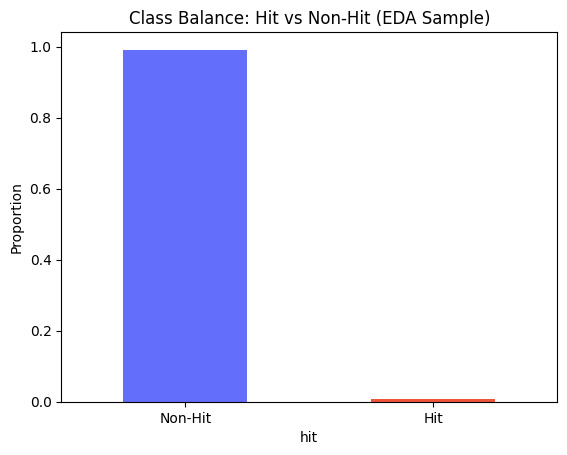

In [154]:
spotify_merged['hit'].value_counts(normalize=True).plot(kind='bar', color=['#636EFA', '#EF553B'])
plt.title("Class Balance: Hit vs Non-Hit (EDA Sample)")
plt.xticks([0, 1], ['Non-Hit', 'Hit'], rotation=0)
plt.ylabel("Proportion")
plt.show()


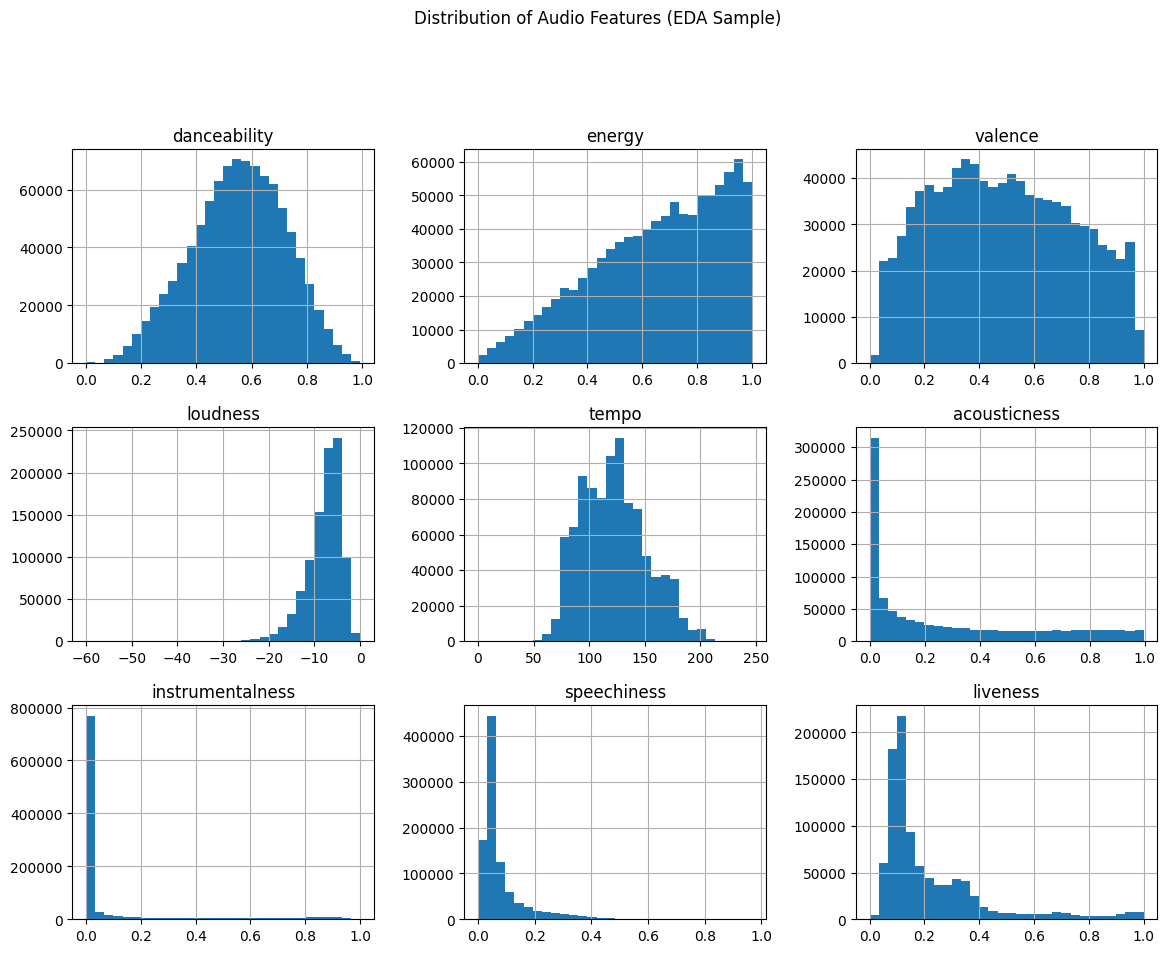

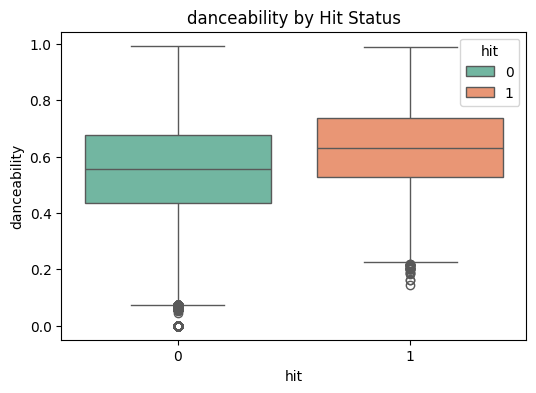

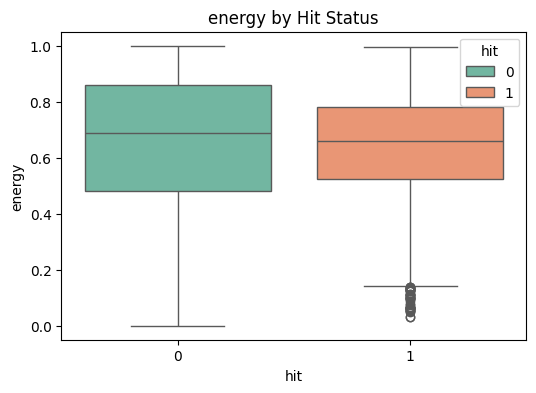

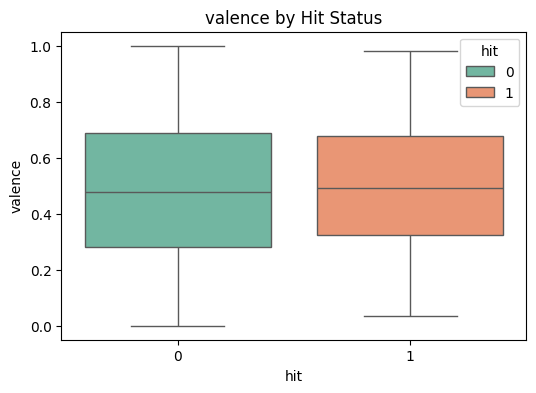

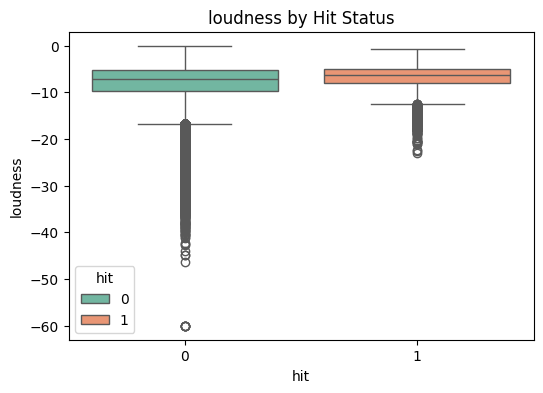

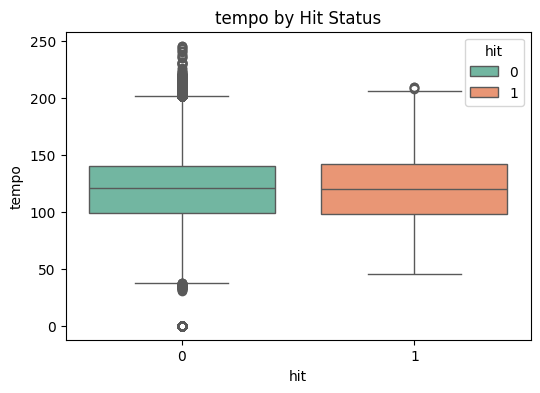

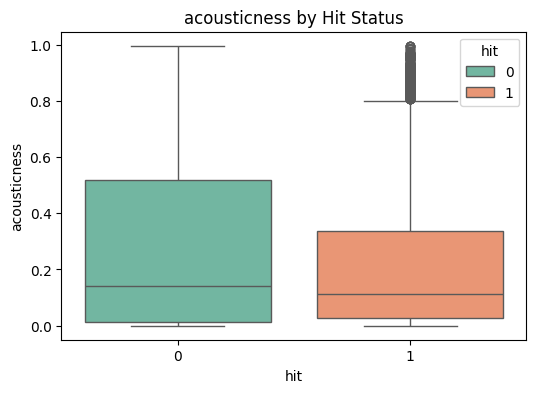

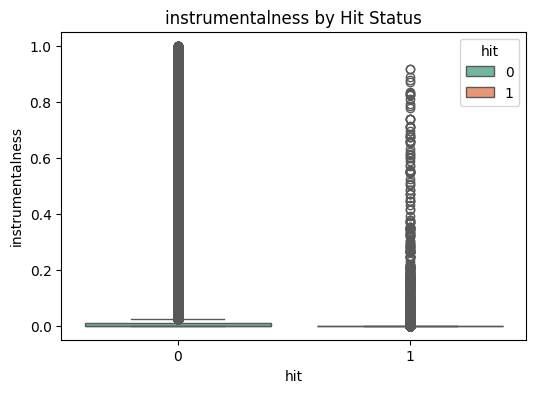

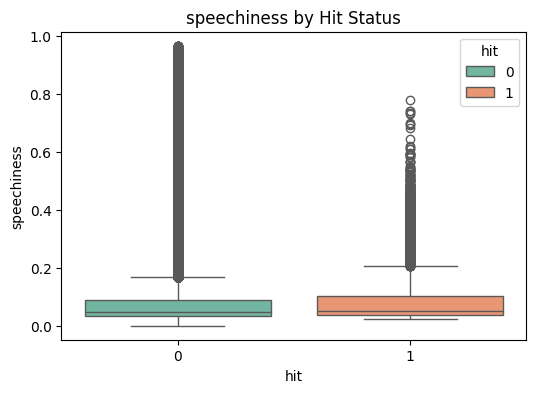

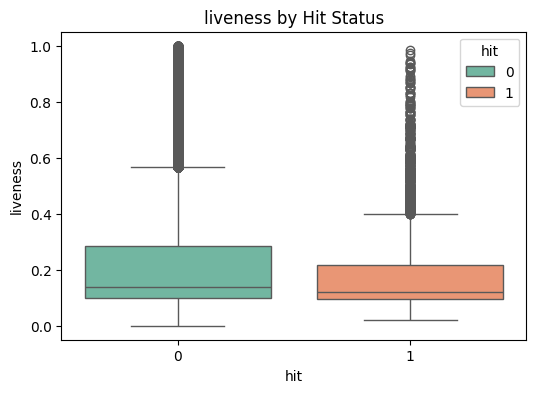

In [155]:
audio_features = [
    'danceability', 'energy', 'valence', 'loudness',
    'tempo', 'acousticness', 'instrumentalness',
    'speechiness', 'liveness']

# Histograms
spotify_merged[audio_features].hist(bins=30, figsize=(14, 10))
plt.suptitle("Distribution of Audio Features (EDA Sample)", y=1.02)
plt.show()

# Boxplots by hit
for feature in audio_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=spotify_merged, x='hit', y=feature, palette='Set2', hue='hit')
    plt.title(f"{feature} by Hit Status")
    plt.show()


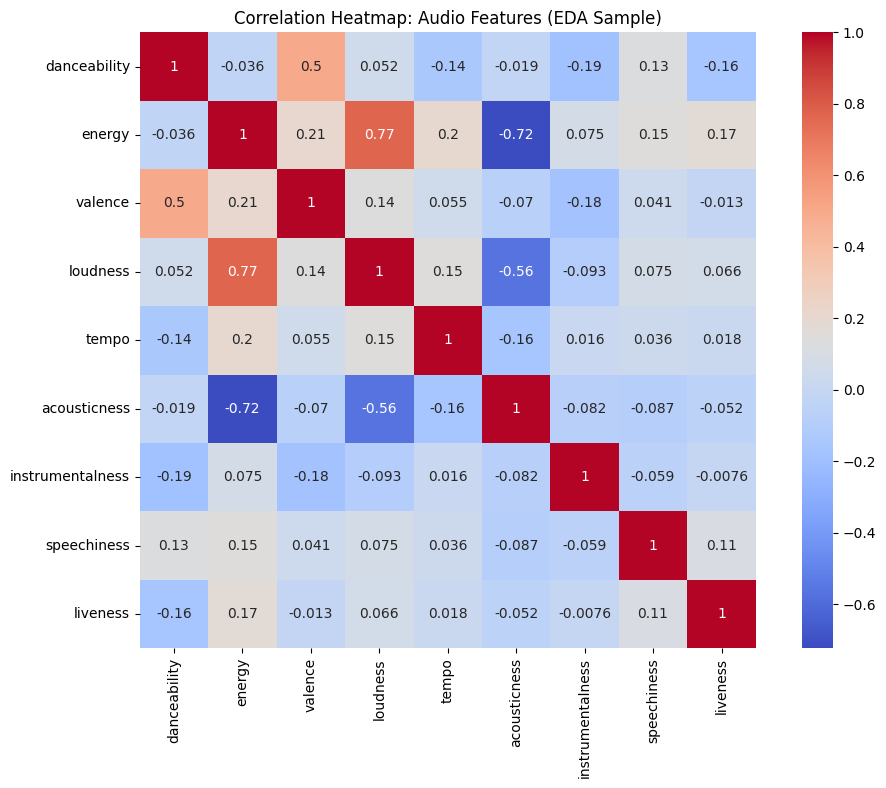

In [156]:
corr = spotify_merged[audio_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Heatmap: Audio Features (EDA Sample)")
plt.show()


Mean values by hit status (EDA Sample):
hit                        0           1
danceability        0.550015    0.629197
energy              0.652557    0.639457
valence             0.488021    0.499148
loudness           -7.843354   -6.791672
tempo             122.228770  121.923652
acousticness        0.283495    0.222793
instrumentalness    0.082503    0.010893
speechiness         0.083524    0.096593
liveness            0.220582    0.175928


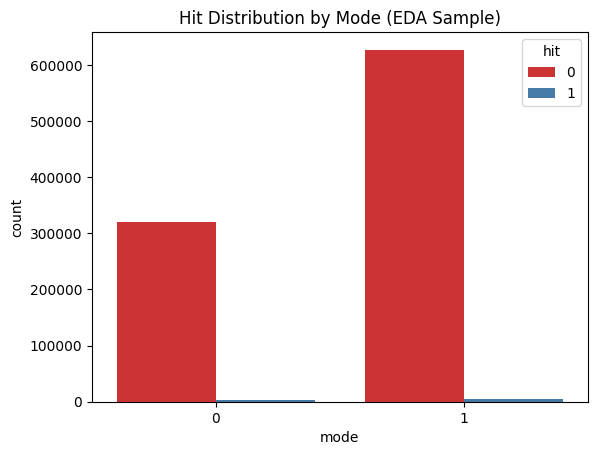

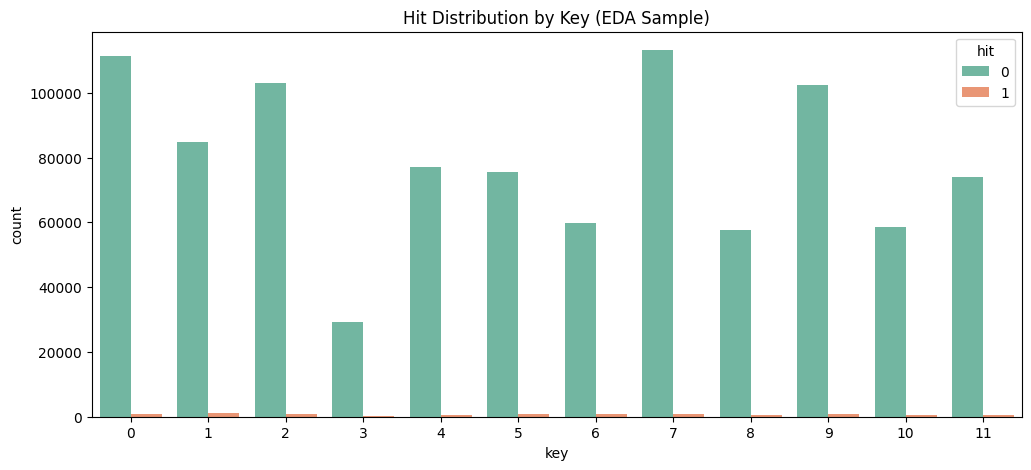

In [157]:
print("Mean values by hit status (EDA Sample):")
print(spotify_merged.groupby('hit')[audio_features].mean().T)

# bar plots for 'key' and 'mode'
if 'mode' in spotify_merged.columns:
    sns.countplot(data=spotify_merged, x='mode', hue='hit', palette='Set1')
    plt.title("Hit Distribution by Mode (EDA Sample)")
    plt.show()

if 'key' in spotify_merged.columns:
    plt.figure(figsize=(12, 5))
    sns.countplot(data=spotify_merged, x='key', hue='hit', palette='Set2')
    plt.title("Hit Distribution by Key (EDA Sample)")
    plt.show()


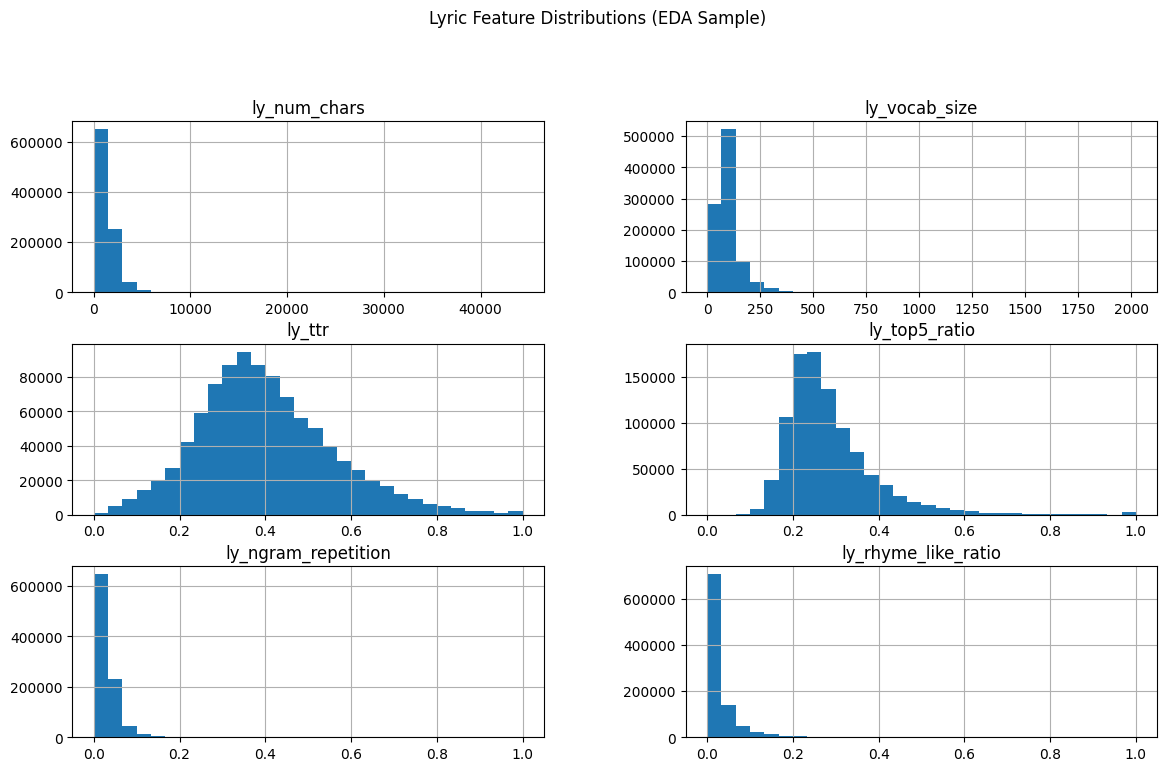

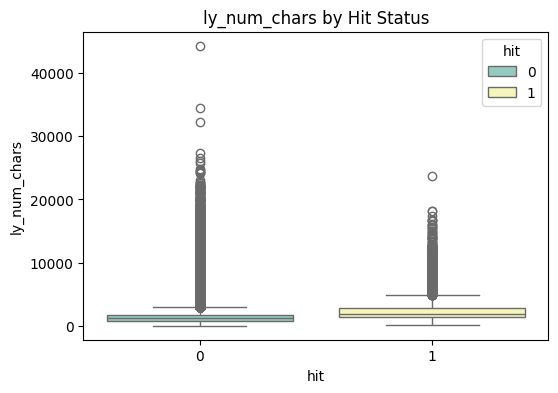

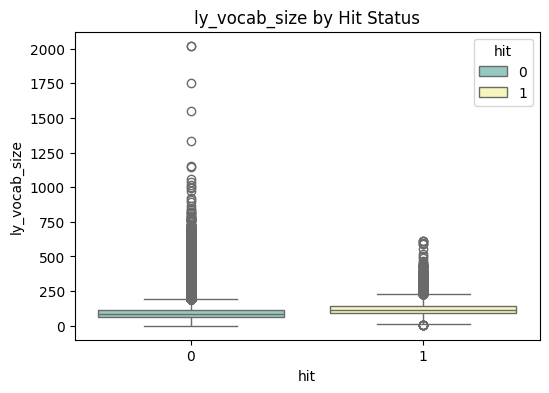

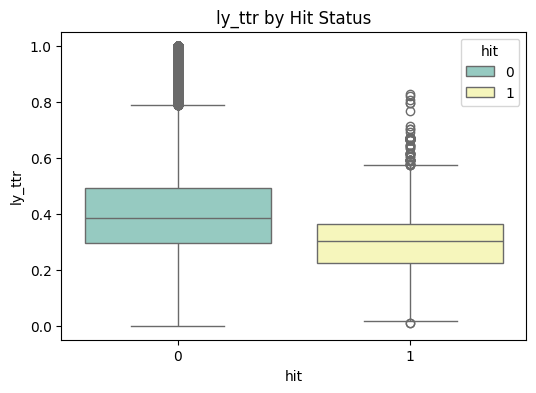

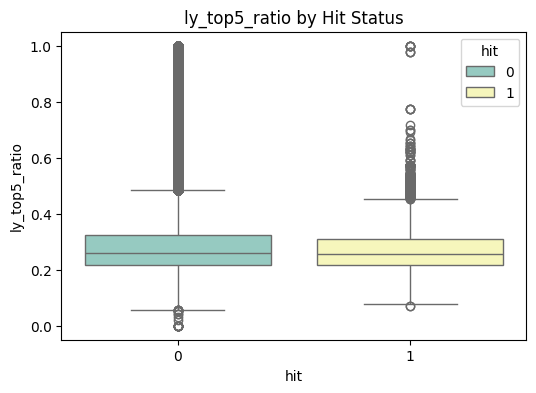

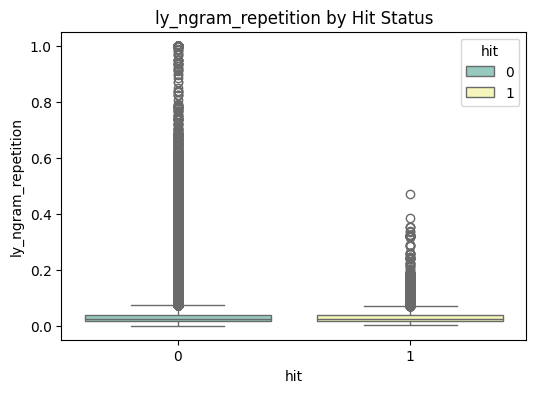

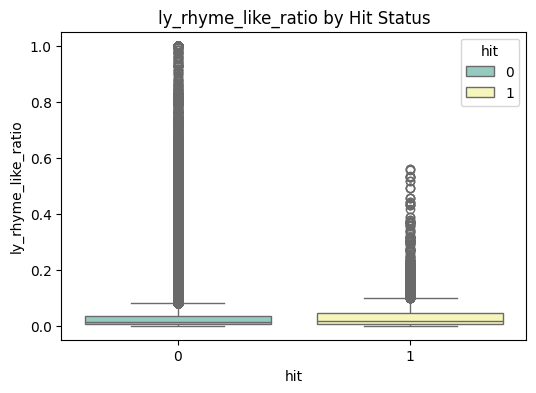

In [158]:
nlp_feats = ['ly_num_chars', 'ly_vocab_size', 'ly_ttr', 'ly_top5_ratio', 'ly_ngram_repetition', 'ly_rhyme_like_ratio']

spotify_merged[nlp_feats].hist(bins=30, figsize=(14, 8))
plt.suptitle("Lyric Feature Distributions (EDA Sample)", y=1.02)
plt.show()

for col in nlp_feats:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=spotify_merged, x='hit', y=col, palette='Set3', hue='hit')
    plt.title(f"{col} by Hit Status")
    plt.show()


In [ ]:
with parallel_backend('threading', n_jobs=-1):
    pairplot_features = ['danceability', 'energy', 'valence', 'loudness', 'tempo']
    
    # Create a copy and convert 'hit' to string for better hue separation
    plot_data = spotify_merged[pairplot_features + ['hit']].copy()
    plot_data['hit'] = plot_data['hit'].astype(str)
    
    
    palette = {
        '1': '#FF4136',     # red for hits
        '0': '#00000020'    # transparent black for non-hits
    }
    
    # Plot
    sns.pairplot(plot_data, vars=pairplot_features, hue='hit', palette=palette, plot_kws={'alpha': 0.8})
    plt.suptitle("Pairplot of Key Audio Features (Colored by Hit)", y=1.02)
plt.show()


In [ ]:
scatter_features = ['danceability', 'energy', 'valence', 'tempo', 'duration_ms']

scatter_matrix(spotify_merged[scatter_features], figsize=(10, 10), diagonal='hist')
plt.suptitle("Scatter Matrix of Selected Features (EDA Sample)", y=1.02)
plt.show()


In [ ]:
# Violin plots for core audio features
for col in ['danceability', 'energy', 'valence', 'loudness', 'tempo', 'acousticness']:
    plt.figure(figsize=(6, 4))
    sns.violinplot(data=spotify_merged, x='hit', y=col, palette='Set2', hue='hit', inner='quartile')
    plt.title(f"{col} Distribution by Hit Status (Violin Plot)")
    plt.xlabel('Hit')
    plt.ylabel(col)
    plt.show()


In [ ]:
features_to_test = [
    'danceability', 'energy', 'valence', 'loudness', 'tempo',
    'acousticness', 'instrumentalness', 'speechiness',
    'ly_vocab_size', 'ly_ttr', 'ly_ngram_repetition']

# Separate hit and non-hit groups
hit_group = spotify_merged[spotify_merged['hit'] == 1]
non_hit_group = spotify_merged[spotify_merged['hit'] == 0]

# Prepare to collect test results
results = []

for feature in features_to_test:
    hit_vals = hit_group[feature].dropna()
    non_hit_vals = non_hit_group[feature].dropna()

    # t-test
    t_stat, t_pval = ttest_ind(hit_vals, non_hit_vals, equal_var=False)

    # Mann–Whitney U test
    u_stat, u_pval = mannwhitneyu(hit_vals, non_hit_vals, alternative='two-sided')

    results.append({
        'Feature': feature,
        'T-test p-value': round(t_pval, 5),
        'U-test p-value': round(u_pval, 5),
        'T-statistic': round(t_stat, 3),
        'U-statistic': round(u_stat, 3)
    })

# Convert to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='T-test p-value'))


## PCA For Visualization

In [ ]:
# Drop non-feature or target columns
exclude_cols = ['id', 'album_name', 'hit', 'hit_hot100', 'hit_radio', 'hit_streaming', 'hit_digital',
                'weeks_in_charts_total', 'peak_rank', 'peak_normalized']
numeric_cols = spotify_merged.select_dtypes(include=['float64', 'int64']).columns.difference(exclude_cols).tolist()

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(spotify_merged[numeric_cols])

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA results to DataFrame
spotify_merged['PCA1'] = X_pca[:, 0]
spotify_merged['PCA2'] = X_pca[:, 1]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=spotify_merged, x='PCA1', y='PCA2', hue='hit', palette='Set1', alpha=0.6)
plt.title("PCA Scatter Plot (First 2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Hit')
plt.tight_layout()
plt.show()

# Training the baseline models

In [ ]:
# Generate timestamped filename
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
#timestamp was used during our work.
filename = "Baseline-models_results.csv"

# Set global random seed
np.random.seed(42)

In [ ]:
# Load training sets
X_train = pd.read_csv("X_train.csv")
X_val = pd.read_csv("X_val.csv")
X_test = pd.read_csv("X_test.csv")

y_train = pd.read_csv("y_train.csv").values.ravel()
y_val = pd.read_csv("y_val.csv").values.ravel()
y_test = pd.read_csv("y_test.csv").values.ravel()

# Load resampled training sets (only X_train has SMOTE/ADASYN applied)
X_train_smote = pd.read_csv("X_train_SMOTE.csv")
y_train_smote = pd.read_csv("y_train_SMOTE.csv").values.ravel()

X_train_adasyn = pd.read_csv("X_train_ADASYN.csv")
y_train_adasyn = pd.read_csv("y_train_ADASYN.csv").values.ravel()

X_train_smote_log = pd.read_csv("X_train_SMOTE_LOG.csv")
y_train_smote_log = pd.read_csv("y_train_SMOTE_LOG.csv").values.ravel()

# Training variants dictionary
data_variants = {
    "Original": (X_train, y_train),
    "SMOTE": (X_train_smote, y_train_smote),
    "SMOTE LOG": (X_train_smote_log, y_train_smote_log),
    "ADASYN": (X_train_adasyn, y_train_adasyn),
}

metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "F2 Score", "ROC AUC", "PR AUC"]
all_results = pd.DataFrame()

Check dataframes

In [ ]:
reference_columns = X_train.columns.tolist()


In [ ]:
def check_column_consistency(reference_df, *datasets):
    ref_columns = set(reference_df.columns)
    for idx, dataset in enumerate(datasets, start=1):
        dataset_columns = set(dataset.columns)
        if ref_columns != dataset_columns:
            missing_in_dataset = ref_columns - dataset_columns
            extra_in_dataset = dataset_columns - ref_columns
            print(f"\nDataset {idx} mismatch:")
            if missing_in_dataset:
                print(" Missing columns:", missing_in_dataset)
            if extra_in_dataset:
                print(" Extra columns:", extra_in_dataset)
        else:
            print(f"Dataset {idx} columns match exactly.")

check_column_consistency(X_train, X_val, X_test)

In [ ]:
def align_columns(df, reference_columns):
    """
    Reorders columns to match the reference columns and adds missing columns with default values.
    """
    # Find missing columns
    missing_cols = set(reference_columns) - set(df.columns)
    # Add missing columns with default value 
    for col in missing_cols:
        df[col] = 0  
    
    # Reorder columns to match reference
    df = df[reference_columns]
    return df

In [ ]:
datasets = [
    ("X_train", X_train),
    ("X_val", X_val),
    ("X_test", X_test),
    ("X_train_SMOTE", X_train_smote),
    ("X_train_ADASYN", X_train_adasyn),
    ("X_train_SMOTE_LOG", X_train_smote_log)
]

# Align all datasets
for name, df in datasets:
    aligned_df = align_columns(df, reference_columns)
    globals()[name] = aligned_df

In [ ]:
for name, df in datasets:
    print(f"{name} columns:", df.columns.tolist())

### Saving models and metadata

In [ ]:
# Create model directory once
model_dir = Path("saved_models")
model_dir.mkdir(exist_ok=True)

def save_model_with_metadata(pipeline, model_name, variant_name, hyperparams, metrics, suffix=""):
    """
    Saves the trained pipeline and its metadata.
    """
    model_id = f"{model_name.replace(' ', '')}_{variant_name.replace(' ', '')}_{suffix}"
    model_path = model_dir / f"{model_id}.pkl"
    meta_path = model_dir / f"{model_id}_meta.json"

    # Save model
    joblib.dump(pipeline, model_path)

    # Save metadata
    metadata = {
        "model_id": model_id,
        "model_type": model_name,
        "variant": variant_name,
        "params": hyperparams,
        "metrics": metrics
    }

    with open(meta_path, "w") as f:
        json.dump(metadata, f, indent=4)

### Logistic regression

In [ ]:
with parallel_backend('threading', n_jobs=-1):
    #C_values and PCA components 
    pca_components = [None, 10, 20, 30]
    C_values = [0.01, 0.1, 1, 10]
    
    # Prepare results and progress
    total_iterations = len(data_variants) * len(pca_components) * len(C_values) * 2  
    results = []
    
    with tqdm(total=total_iterations, desc="Logistic Regression tuning (val set)") as pbar:
        best_scores = {} 
        for variant_name, (X_tr, y_tr) in data_variants.items():
            for n_components in pca_components:
                for C in C_values:
                    for balanced in [False, True]:
                        steps = [('scaler', StandardScaler())]
    
                        if n_components is not None:
                            max_components = min(X_tr.shape[0], X_tr.shape[1])
                            if n_components >= max_components:
                                pbar.update(1)
                                continue
                            steps.append(('pca', PCA(n_components=n_components, random_state=42)))
    
                        lr_params = {
                            "C": C,
                            "max_iter": 1000,
                            "solver": 'lbfgs',
                            "random_state": 42
                        }
    
                        if balanced:
                            lr_params["class_weight"] = "balanced"
    
                        steps.append(('logreg', LogisticRegression(**lr_params)))
                        pipeline = Pipeline(steps)
    
                        pipeline.fit(X_tr, y_tr)
                        y_pred = pipeline.predict(X_val)
                        y_prob = pipeline.predict_proba(X_val)[:, 1]
    
                        acc = accuracy_score(y_val, y_pred)
                        prec = precision_score(y_val, y_pred, zero_division=0)
                        rec = recall_score(y_val, y_pred, zero_division=0)
                        f1 = f1_score(y_val, y_pred, zero_division=0)
                        f2 = fbeta_score(y_val, y_pred, beta=2, zero_division=0)
                        roc_auc = roc_auc_score(y_val, y_prob)
                        pr_auc = average_precision_score(y_val, y_prob)
    
                        results.append({
                            "Model": "Logistic Regression",
                            "Variant": variant_name,
                            "PCA_Components": n_components if n_components is not None else "None",
                            "C": C,
                            "Class_Weight_Balanced": balanced,
                            "Accuracy": acc,
                            "Precision": prec,
                            "Recall": rec,
                            "F1 Score": f1,
                            "F2 Score": f2,
                            "ROC AUC": roc_auc,
                            "PR AUC": pr_auc
                        })
    
                        # Record results in dataframe
                        results.append({
                            "Model": "Logistic Regression",
                            "Variant": variant_name,
                            "PCA_Components": n_components if n_components is not None else "None",
                            "C": C,
                            "Class_Weight_Balanced": balanced,
                            "Accuracy": acc,
                            "Precision": prec,
                            "Recall": rec,
                            "F1 Score": f1,
                            "F2 Score": f2,
                            "ROC AUC": roc_auc,
                            "PR AUC": pr_auc
                        })
    
                        #store best model by F2 score
                        key = ("Logistic Regression", variant_name)
                        suffix = f"pca{n_components if n_components is not None else 'None'}_C{C}_balanced{balanced}"
                        metrics_dict = {
                            "Accuracy": acc,
                            "Precision": prec,
                            "Recall": rec,
                            "F1 Score": f1,
                            "F2 Score": f2,
                            "ROC AUC": roc_auc,
                            "PR AUC": pr_auc
                        }
    
                        if key not in best_scores or f2 > best_scores[key]["F2 Score"]:
                            best_scores[key] = {
                                "F2 Score": f2,
                                "metrics": metrics_dict,
                                "pipeline": pipeline,
                                "hyperparams": lr_params,
                                "suffix": suffix
                            }
    
                        pbar.update(1)
    
    # Save and return results
    logreg_results = pd.DataFrame(results)
    all_results = pd.concat([all_results, logreg_results], ignore_index=True)
    # Save results with timestamped filename
    all_results.to_csv(filename, index=False)
    
    # Save only the best models
    for (model_name, variant_name), info in best_scores.items():
        save_model_with_metadata(
            pipeline=info["pipeline"],
            model_name=model_name,
            variant_name=variant_name,
            hyperparams=info["hyperparams"],
            metrics=info["metrics"],
            suffix=info["suffix"]
        )

logreg_results

In [ ]:
df_dt = all_results[all_results['Model'] == 'Logistic Regression'].copy()
df_dt['C'] = pd.to_numeric(df_dt['C'], errors='coerce')

for metric in metrics:
    plt.figure(figsize=(8, 6))
    sns.lineplot(
        data=df_dt,
        x="C",
        y=metric,
        hue="Variant",
        style="Class_Weight_Balanced",
        markers=True,
        dashes=False,
        palette="Set2"
    )
    plt.title(f"Logistic Regression: {metric} vs C")
    plt.xlabel("C (Inverse Regularization Strength)")
    plt.ylabel(metric)
    plt.xscale("log")  
    plt.grid(True)
    plt.tight_layout()
    plt.legend(title="Variant / Class Weight")
    plt.show()

In [ ]:
# Logistic Regression (C tuning)
df_lr = all_results[all_results["Model"] == "Logistic Regression"].dropna(subset=["C"])
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_lr, x="C", y="F2 Score", hue="Variant", style="Class_Weight_Balanced", marker="o")
plt.xscale("log")
plt.title("F2 Score vs C (Logistic Regression)")
plt.tight_layout()
plt.show()

### Decision tree

In [ ]:
with parallel_backend('threading', n_jobs=-1):
    # Tree depths 
    max_depths = [3, 5, 10, None]
    
    # Run experiments
    results = []
    total_iterations = len(data_variants) * len(max_depths) * 2  # *2 for with/without class_weight
    
    with tqdm(total=total_iterations, desc="Running Decision Tree experiments") as pbar:
        best_scores = {}  
    
        for variant_name, (X_tr, y_tr) in data_variants.items():
            for max_depth in max_depths:
                for balanced in [False, True]:
                    dt_params = {
                        "max_depth": max_depth,
                        "random_state": 42
                    }
                    if balanced:
                        dt_params["class_weight"] = "balanced"
    
                    pipeline = Pipeline([
                        ('scaler', StandardScaler()),
                        ('clf', DecisionTreeClassifier(**dt_params))
                    ])
    
                    pipeline.fit(X_tr, y_tr)
                    y_pred = pipeline.predict(X_val)
                    y_prob = pipeline.predict_proba(X_val)[:, 1]
    
                    acc = accuracy_score(y_val, y_pred)
                    prec = precision_score(y_val, y_pred, zero_division=0)
                    rec = recall_score(y_val, y_pred, zero_division=0)
                    f1 = f1_score(y_val, y_pred, zero_division=0)
                    f2 = fbeta_score(y_val, y_pred, beta=2, zero_division=0)
                    roc_auc = roc_auc_score(y_val, y_prob)
                    pr_auc = average_precision_score(y_val, y_prob)
    
                    results.append({
                        "Model": "Decision Tree",
                        "Variant": variant_name,
                        "Max_Depth": max_depth if max_depth is not None else "None",
                        "Class_Weight_Balanced": balanced,
                        "Accuracy": acc,
                        "Precision": prec,
                        "Recall": rec,
                        "F1 Score": f1,
                        "F2 Score": f2,
                        "ROC AUC": roc_auc,
                        "PR AUC": pr_auc
                    })
    
                    # Track best model by F2 score
                    key = ("Decision Tree", variant_name)
                    suffix = f"depth{max_depth if max_depth is not None else 'None'}_balanced{balanced}"
                    metrics_dict = {
                        "Accuracy": acc,
                        "Precision": prec,
                        "Recall": rec,
                        "F1 Score": f1,
                        "F2 Score": f2,
                        "ROC AUC": roc_auc,
                        "PR AUC": pr_auc
                    }
    
                    if key not in best_scores or f2 > best_scores[key]["F2 Score"]:
                        best_scores[key] = {
                            "F2 Score": f2,
                            "metrics": metrics_dict,
                            "pipeline": pipeline,
                            "hyperparams": dt_params,
                            "suffix": suffix
                        }
    
                    pbar.update(1)
    
    # Save and display
    dt_results = pd.DataFrame(results)
    all_results = pd.concat([all_results, dt_results], ignore_index=True)
    
    # Save results with timestamped filename
    all_results.to_csv(filename, index=False)
    
    # Save best models
    for (model_name, variant_name), info in best_scores.items():
        save_model_with_metadata(
            pipeline=info["pipeline"],
            model_name=model_name,
            variant_name=variant_name,
            hyperparams=info["hyperparams"],
            metrics=info["metrics"],
            suffix=info["suffix"]
        )

dt_results

In [ ]:
df_dt = all_results[all_results['Model'] == 'Decision Tree'].copy()
df_dt['max_depth'] = pd.to_numeric(df_dt['Max_Depth'], errors='coerce')

for metric in metrics:
    plt.figure()
    sns.lineplot(data=df_dt, x="max_depth", y=metric, hue="Variant", marker='o', palette="Set2")
    plt.title(f"Decision Tree: {metric} vs max_depth")
    plt.xlabel("max_depth")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

### Random Forest

In [ ]:
with parallel_backend('threading', n_jobs=-1):
    # Parameters
    pca_components = [None, 10, 20, 30]
    n_estimators_list = [50, 100, 200]
    
    # Prepare results
    total_iterations = len(data_variants) * len(pca_components) * len(n_estimators_list) * 2  # *2 for balanced/unbalanced
    results = []
    
    with tqdm(total=total_iterations, desc="Running Random Forest experiments") as pbar:
        best_scores = {}  
    
        for variant_name, (X_tr, y_tr) in data_variants.items():
            for n_components in pca_components:
                for n_estimators in n_estimators_list:
                    for balanced in [False, True]:
                        steps = [('scaler', StandardScaler())]
    
                        if n_components is not None:
                            max_components = min(X_tr.shape[0], X_tr.shape[1])
                            if n_components >= max_components:
                                pbar.update(1)
                                continue
                            steps.append(('pca', PCA(n_components=n_components, random_state=42)))
    
                        rf_params = {
                            "n_estimators": n_estimators,
                            "random_state": 42,
                            "n_jobs": -1
                        }
                        if balanced:
                            rf_params["class_weight"] = "balanced"
    
                        steps.append(('rf', RandomForestClassifier(**rf_params)))
                        pipeline = Pipeline(steps)
    
                        pipeline.fit(X_tr, y_tr)
                        y_pred = pipeline.predict(X_val)
                        y_prob = pipeline.predict_proba(X_val)[:, 1]
    
                        acc = accuracy_score(y_val, y_pred)
                        prec = precision_score(y_val, y_pred, zero_division=0)
                        rec = recall_score(y_val, y_pred, zero_division=0)
                        f1 = f1_score(y_val, y_pred, zero_division=0)
                        f2 = fbeta_score(y_val, y_pred, beta=2, zero_division=0)
                        roc_auc = roc_auc_score(y_val, y_prob)
                        pr_auc = average_precision_score(y_val, y_prob)
    
                        results.append({
                            "Model": "Random Forest",
                            "Variant": variant_name,
                            "PCA_Components": n_components if n_components is not None else "None",
                            "n_estimators": n_estimators,
                            "Class_Weight_Balanced": balanced,
                            "Accuracy": acc,
                            "Precision": prec,
                            "Recall": rec,
                            "F1 Score": f1,
                            "F2 Score": f2,
                            "ROC AUC": roc_auc,
                            "PR AUC": pr_auc
                        })
    
                        # Save only best model per (model, variant) based on F2
                        key = ("Random Forest", variant_name)
                        suffix = f"pca{n_components if n_components is not None else 'None'}_n{n_estimators}_balanced{balanced}"
                        metrics_dict = {
                            "Accuracy": acc,
                            "Precision": prec,
                            "Recall": rec,
                            "F1 Score": f1,
                            "F2 Score": f2,
                            "ROC AUC": roc_auc,
                            "PR AUC": pr_auc
                        }
    
                        if key not in best_scores or f2 > best_scores[key]["F2 Score"]:
                            best_scores[key] = {
                                "F2 Score": f2,
                                "metrics": metrics_dict,
                                "pipeline": pipeline,
                                "hyperparams": rf_params,
                                "suffix": suffix
                            }
    
                        pbar.update(1)
    
    # Save and show results
    rf_results = pd.DataFrame(results)
    all_results = pd.concat([all_results, rf_results], ignore_index=True)
    
    # Save results with timestamped filename
    all_results.to_csv(filename, index=False)
    
    # Save only best models
    for (model_name, variant_name), info in best_scores.items():
        save_model_with_metadata(
            pipeline=info["pipeline"],
            model_name=model_name,
            variant_name=variant_name,
            hyperparams=info["hyperparams"],
            metrics=info["metrics"],
            suffix=info["suffix"]
        )

rf_results

In [ ]:
df_rf = all_results[all_results['Model'] == 'Random Forest'].copy()

for metric in metrics:
    plt.figure()
    sns.lineplot(data=df_rf, x="n_estimators", y=metric, hue="Variant", marker='o', palette="Set2")
    plt.title(f"Random Forest: {metric} vs n_estimators")
    plt.xlabel("n_estimators")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

### XGBoost 

In [ ]:
with parallel_backend('threading', n_jobs=-1):
    # Parameters
    pca_components = [None, 10, 20, 30]
    xgb_params = [
        {"n_estimators": 100, "max_depth": 3, "learning_rate": 0.1},
        {"n_estimators": 100, "max_depth": 5, "learning_rate": 0.1},
        {"n_estimators": 200, "max_depth": 3, "learning_rate": 0.05},
        {"n_estimators": 200, "max_depth": 5, "learning_rate": 0.05},
    ]
    
    # Prepare results and progress
    total_iterations = len(data_variants) * len(pca_components) * len(xgb_params) * 2  
    results = []
    
    with tqdm(total=total_iterations, desc="Running XGBoost experiments") as pbar:
        best_scores = {}  
    
        for variant_name, (X_tr, y_tr) in data_variants.items():
            # Compute scale_pos_weight once per variant
            pos = sum(y_tr)
            neg = len(y_tr) - pos
            scale_weight = neg / pos if pos > 0 else 1.0
    
            for n_components in pca_components:
                for params in xgb_params:
                    for balanced in [False, True]:
                        steps = [('scaler', StandardScaler())]
    
                        if n_components is not None:
                            max_components = min(X_tr.shape[0], X_tr.shape[1])
                            if n_components >= max_components:
                                pbar.update(1)
                                continue
                            steps.append(('pca', PCA(n_components=n_components, random_state=42)))
    
                        xgb_clf_params = {
                            "use_label_encoder": False,
                            "eval_metric": "logloss",
                            "n_estimators": params["n_estimators"],
                            "max_depth": params["max_depth"],
                            "learning_rate": params["learning_rate"],
                            "random_state": 42,
                            "verbosity": 0
                        }
    
                        if balanced:
                            xgb_clf_params["scale_pos_weight"] = scale_weight
    
                        xgb_clf = XGBClassifier(**xgb_clf_params)
                        steps.append(('xgb', xgb_clf))
                        pipeline = Pipeline(steps)
    
                        pipeline.fit(X_tr, y_tr)
                        y_pred = pipeline.predict(X_val)
                        y_prob = pipeline.predict_proba(X_val)[:, 1]
    
                        acc = accuracy_score(y_val, y_pred)
                        prec = precision_score(y_val, y_pred, zero_division=0)
                        rec = recall_score(y_val, y_pred, zero_division=0)
                        f1 = f1_score(y_val, y_pred, zero_division=0)
                        f2 = fbeta_score(y_val, y_pred, beta=2, zero_division=0)
                        roc_auc = roc_auc_score(y_val, y_prob)
                        pr_auc = average_precision_score(y_val, y_prob)
    
                        results.append({
                            "Model": "XGBoost",
                            "Variant": variant_name,
                            "PCA_Components": n_components if n_components is not None else "None",
                            "n_estimators": params["n_estimators"],
                            "max_depth": params["max_depth"],
                            "learning_rate": params["learning_rate"],
                            "Class_Weight_Balanced": balanced,
                            "Accuracy": acc,
                            "Precision": prec,
                            "Recall": rec,
                            "F1 Score": f1,
                            "F2 Score": f2,
                            "ROC AUC": roc_auc,
                            "PR AUC": pr_auc
                        })
    
                        # Save only best model per (model, variant) based on F2
                        key = ("XGBoost", variant_name)
                        suffix = f"pca{n_components if n_components is not None else 'None'}_n{params['n_estimators']}_depth{params['max_depth']}_lr{params['learning_rate']}_balanced{balanced}"
                        metrics_dict = {
                            "Accuracy": acc,
                            "Precision": prec,
                            "Recall": rec,
                            "F1 Score": f1,
                            "F2 Score": f2,
                            "ROC AUC": roc_auc,
                            "PR AUC": pr_auc
                        }
    
                        if key not in best_scores or f2 > best_scores[key]["F2 Score"]:
                            best_scores[key] = {
                                "F2 Score": f2,
                                "metrics": metrics_dict,
                                "pipeline": pipeline,
                                "hyperparams": xgb_clf_params,
                                "suffix": suffix
                            }
    
                        pbar.update(1)
    
    # Save and show results
    xgb_results = pd.DataFrame(results)
    all_results = pd.concat([all_results, xgb_results], ignore_index=True)
    
    # Save results with timestamped filename
    all_results.to_csv(filename, index=False)
    
    # Save only best models
    for (model_name, variant_name), info in best_scores.items():
        save_model_with_metadata(
            pipeline=info["pipeline"],
            model_name=model_name,
            variant_name=variant_name,
            hyperparams=info["hyperparams"],
            metrics=info["metrics"],
            suffix=info["suffix"]
        )

xgb_results

### CatBoost

In [ ]:
with parallel_backend('threading', n_jobs=-1):
    # Parameters
    pca_components = [None, 10, 20, 30]
    catboost_params = [
        {"iterations": 100, "depth": 4, "learning_rate": 0.1},
        {"iterations": 100, "depth": 6, "learning_rate": 0.1},
        {"iterations": 200, "depth": 4, "learning_rate": 0.05},
        {"iterations": 200, "depth": 6, "learning_rate": 0.05},
    ]
    
    # Prepare results
    total_iterations = len(data_variants) * len(pca_components) * len(catboost_params) * 2 
    results = []
    
    with tqdm(total=total_iterations, desc="Running CatBoost experiments") as pbar:
        best_scores = {}  
    
        for variant_name, (X_tr, y_tr) in data_variants.items():
            for n_components in pca_components:
                for params in catboost_params:
                    for balanced in [False, True]:
    
                        steps = [('scaler', StandardScaler())]  # For consistency
    
                        if n_components is not None:
                            max_components = min(X_tr.shape[0], X_tr.shape[1])
                            if n_components >= max_components:
                                pbar.update(1)
                                continue
                            steps.append(('pca', PCA(n_components=n_components, random_state=42)))
    
                        cat_params = {
                            "iterations": params["iterations"],
                            "depth": params["depth"],
                            "learning_rate": params["learning_rate"],
                            "verbose": 0,
                            "random_state": 42
                        }
    
                        if balanced:
                            cat_params["auto_class_weights"] = "Balanced"
    
                        catboost_clf = CatBoostClassifier(**cat_params)
                        steps.append(('catboost', catboost_clf))
                        pipeline = Pipeline(steps)
    
                        pipeline.fit(X_tr, y_tr)
                        y_pred = pipeline.predict(X_val)
                        y_prob = pipeline.predict_proba(X_val)[:, 1]
    
                        acc = accuracy_score(y_val, y_pred)
                        prec = precision_score(y_val, y_pred, zero_division=0)
                        rec = recall_score(y_val, y_pred, zero_division=0)
                        f1 = f1_score(y_val, y_pred, zero_division=0)
                        f2 = fbeta_score(y_val, y_pred, beta=2, zero_division=0)
                        roc_auc = roc_auc_score(y_val, y_prob)
                        pr_auc = average_precision_score(y_val, y_prob)
    
                        results.append({
                            "Model": "CatBoost",
                            "Variant": variant_name,
                            "PCA_Components": n_components if n_components is not None else "None",
                            "iterations": params["iterations"],
                            "depth": params["depth"],
                            "learning_rate": params["learning_rate"],
                            "Class_Weight_Balanced": balanced,
                            "Accuracy": acc,
                            "Precision": prec,
                            "Recall": rec,
                            "F1 Score": f1,
                            "F2 Score": f2,
                            "ROC AUC": roc_auc,
                            "PR AUC": pr_auc
                        })
    
                        # Save only best model per (model, variant) based on F2
                        key = ("CatBoost", variant_name)
                        suffix = f"pca{n_components if n_components is not None else 'None'}_iter{params['iterations']}_depth{params['depth']}_lr{params['learning_rate']}_balanced{balanced}"
                        metrics_dict = {
                            "Accuracy": acc,
                            "Precision": prec,
                            "Recall": rec,
                            "F1 Score": f1,
                            "F2 Score": f2,
                            "ROC AUC": roc_auc,
                            "PR AUC": pr_auc
                        }
    
                        if key not in best_scores or f2 > best_scores[key]["F2 Score"]:
                            best_scores[key] = {
                                "F2 Score": f2,
                                "metrics": metrics_dict,
                                "pipeline": pipeline,
                                "hyperparams": cat_params,
                                "suffix": suffix
                            }
    
                        pbar.update(1)
    
    # Save and display results
    catboost_results = pd.DataFrame(results)
    all_results = pd.concat([all_results, catboost_results], ignore_index=True)
    
    # Save results with timestamped filename
    all_results.to_csv(filename, index=False)
    
    # Save best models
    for (model_name, variant_name), info in best_scores.items():
        save_model_with_metadata(
            pipeline=info["pipeline"],
            model_name=model_name,
            variant_name=variant_name,
            hyperparams=info["hyperparams"],
            metrics=info["metrics"],
            suffix=info["suffix"]
        )

catboost_results

### LightGBM

In [ ]:

with parallel_backend('threading', n_jobs=-1):
    # Hyperparameter grids
    n_estimators_list = [100, 200]
    learning_rate_list = [0.1, 0.01]
    
    # Prepare results and progress bar
    total_iterations = (
        len(data_variants)
        * len(n_estimators_list)
        * len(learning_rate_list)
        * 2  # for class_weight 
    )
    results = []
    
    with tqdm(total=total_iterations, desc="LightGBM tuning (val set)") as pbar:
        best_scores = {} 
    
        for variant_name, (X_tr, y_tr) in data_variants.items():
            for n_estimators in n_estimators_list:
                for lr in learning_rate_list:
                    for balanced in [False, True]:
                        # Build pipeline 
                        steps = [
                            ('scaler', StandardScaler()),
                            ('lgb', lgb.LGBMClassifier(
                                objective='binary',
                                boosting_type='gbdt',
                                n_estimators=n_estimators,
                                learning_rate=lr,
                                class_weight='balanced' if balanced else None,
                                random_state=42
                            ))
                        ]
                        pipeline = Pipeline(steps)
    
                        # Train & predict
                        pipeline.fit(X_tr, y_tr)
                        y_pred = pipeline.predict(X_val)
                        y_prob = pipeline.predict_proba(X_val)[:, 1]
    
                        # Compute metrics
                        acc     = accuracy_score(y_val, y_pred)
                        prec    = precision_score(y_val, y_pred, zero_division=0)
                        rec     = recall_score(y_val, y_pred, zero_division=0)
                        f1      = f1_score(y_val, y_pred, zero_division=0)
                        f2      = fbeta_score(y_val, y_pred, beta=2, zero_division=0)
                        roc_auc = roc_auc_score(y_val, y_prob)
                        pr_auc  = average_precision_score(y_val, y_prob)
    
                        # Record results
                        results.append({
                            "Model": "LightGBM",
                            "Variant": variant_name,
                            "n_estimators": n_estimators,
                            "learning_rate": lr,
                            "Class_Weight_Balanced": balanced,
                            "Accuracy": acc,
                            "Precision": prec,
                            "Recall": rec,
                            "F1 Score": f1,
                            "F2 Score": f2,
                            "ROC AUC": roc_auc,
                            "PR AUC": pr_auc
                        })
    
                        # Save only best model per (Model, Variant)
                        key = ("LightGBM", variant_name)
                        suffix = f"n{n_estimators}_lr{lr}_balanced{balanced}"
                        metrics_dict = {
                            "Accuracy": acc,
                            "Precision": prec,
                            "Recall": rec,
                            "F1 Score": f1,
                            "F2 Score": f2,
                            "ROC AUC": roc_auc,
                            "PR AUC": pr_auc
                        }
                        hyperparams = {
                            "n_estimators": n_estimators,
                            "learning_rate": lr,
                            "class_weight": 'balanced' if balanced else None
                        }
    
                        if key not in best_scores or f2 > best_scores[key]["F2 Score"]:
                            best_scores[key] = {
                                "F2 Score": f2,
                                "metrics": metrics_dict,
                                "pipeline": pipeline,
                                "hyperparams": hyperparams,
                                "suffix": suffix
                            }
    
                        pbar.update(1)
    
    # Save all results
    lgb_results = pd.DataFrame(results)
    all_results = pd.concat([all_results, lgb_results], ignore_index=True)
    
    # Save results with timestamped filename
    all_results.to_csv(filename, index=False)
    
    # Save best models
    for (model_name, variant_name), info in best_scores.items():
        save_model_with_metadata(
            pipeline=info["pipeline"],
            model_name=model_name,
            variant_name=variant_name,
            hyperparams=info["hyperparams"],
            metrics=info["metrics"],
            suffix=info["suffix"]
        )

lgb_results

## Soft voting classifier

In [ ]:
with parallel_backend('threading', n_jobs=-1):
    # Prepare results container
    results = []
    
    with tqdm(total=len(data_variants), desc="VotingClassifier Evaluation") as pbar:
        best_scores = {} 
    
        for variant_name, (X_tr, y_tr) in data_variants.items():
            # Define base models
            estimators = [
                ('lr', LogisticRegression(C=1, max_iter=1000, random_state=42)),
                ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)),
                ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42)),
                ('lgb', lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42)),
            ]
    
            # Build pipeline
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('voting', VotingClassifier(estimators=estimators, voting='soft'))
            ])
    
            # Train and predict
            pipeline.fit(X_tr, y_tr)
            y_pred = pipeline.predict(X_val)
            y_prob = pipeline.predict_proba(X_val)[:, 1]
    
            # Evaluate metrics
            acc     = accuracy_score(y_val, y_pred)
            prec    = precision_score(y_val, y_pred, zero_division=0)
            rec     = recall_score(y_val, y_pred, zero_division=0)
            f1      = f1_score(y_val, y_pred, zero_division=0)
            f2      = fbeta_score(y_val, y_pred, beta=2, zero_division=0)
            roc_auc = roc_auc_score(y_val, y_prob)
            pr_auc  = average_precision_score(y_val, y_prob)
    
            # Save results
            results.append({
                "Model": "VotingClassifier (Soft)",
                "Variant": variant_name,
                "n_estimators": 100,
                "learning_rate": None,
                "Class_Weight_Balanced": True,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1 Score": f1,
                "F2 Score": f2,
                "ROC AUC": roc_auc,
                "PR AUC": pr_auc
            })
    
            # Save best per (Model, Variant)
            key = ("VotingClassifier (Soft)", variant_name)
            suffix = "softvote_balanced"
            metrics_dict = {
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1 Score": f1,
                "F2 Score": f2,
                "ROC AUC": roc_auc,
                "PR AUC": pr_auc
            }
            hyperparams = {
                "base_models": ["lr", "rf", "xgb", "lgb"],
                "voting": "soft",
                "n_estimators": 100
            }
    
            if key not in best_scores or f2 > best_scores[key]["F2 Score"]:
                best_scores[key] = {
                    "F2 Score": f2,
                    "metrics": metrics_dict,
                    "pipeline": pipeline,
                    "hyperparams": hyperparams,
                    "suffix": suffix
                }
    
            pbar.update(1)
    
    # results
    voting_results = pd.DataFrame(results)
    all_results = pd.concat([all_results, voting_results], ignore_index=True)
    
    # Save results with timestamped filename
    all_results.to_csv(filename, index=False)
    
    # Save best models
    for (model_name, variant_name), info in best_scores.items():
        save_model_with_metadata(
            pipeline=info["pipeline"],
            model_name=model_name,
            variant_name=variant_name,
            hyperparams=info["hyperparams"],
            metrics=info["metrics"],
            suffix=info["suffix"]
        )

voting_results

## Stacking classifier

In [ ]:
with parallel_backend('threading', n_jobs=-1):
    # Prepare results container
    results = []
    
    with tqdm(total=len(data_variants), desc="StackingClassifier Evaluation") as pbar:
        best_scores = {}  
    
        for variant_name, (X_tr, y_tr) in data_variants.items():
            # Define base learners
            base_learners = [
                ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)),
                ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42)),
                ('lgb', lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42)),
            ]
    
            # Final estimator
            final_estimator = LogisticRegression(max_iter=1000, random_state=42)
    
            # Build stacking pipeline
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('stacking', StackingClassifier(
                    estimators=base_learners,
                    final_estimator=final_estimator,
                    passthrough=True,
                    cv=5,
                    n_jobs=-1
                ))
            ])
    
            # Train and predict
            pipeline.fit(X_tr, y_tr)
            y_pred = pipeline.predict(X_val)
            y_prob = pipeline.predict_proba(X_val)[:, 1]
    
            # Evaluate metrics
            acc     = accuracy_score(y_val, y_pred)
            prec    = precision_score(y_val, y_pred, zero_division=0)
            rec     = recall_score(y_val, y_pred, zero_division=0)
            f1      = f1_score(y_val, y_pred, zero_division=0)
            f2      = fbeta_score(y_val, y_pred, beta=2, zero_division=0)
            roc_auc = roc_auc_score(y_val, y_prob)
            pr_auc  = average_precision_score(y_val, y_prob)
    
            # Save results
            results.append({
                "Model": "StackingClassifier",
                "Variant": variant_name,
                "n_estimators": 100,
                "learning_rate": None,
                "Class_Weight_Balanced": True,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1 Score": f1,
                "F2 Score": f2,
                "ROC AUC": roc_auc,
                "PR AUC": pr_auc
            })
    
            # Save best per (Model, Variant)
            key = ("StackingClassifier", variant_name)
            suffix = "stacked_balanced"
            metrics_dict = {
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1 Score": f1,
                "F2 Score": f2,
                "ROC AUC": roc_auc,
                "PR AUC": pr_auc
            }
            hyperparams = {
                "base_models": ["rf", "xgb", "lgb"],
                "meta_model": "logreg",
                "passthrough": True,
                "cv": 5
            }
    
            if key not in best_scores or f2 > best_scores[key]["F2 Score"]:
                best_scores[key] = {
                    "F2 Score": f2,
                    "metrics": metrics_dict,
                    "pipeline": pipeline,
                    "hyperparams": hyperparams,
                    "suffix": suffix
                }
    
            pbar.update(1)
    
    #  results
    stacking_results = pd.DataFrame(results)
    all_results = pd.concat([all_results, stacking_results], ignore_index=True)
    
    # Save results with timestamped filename
    all_results.to_csv(filename, index=False)
    
    # Save best models
    for (model_name, variant_name), info in best_scores.items():
        save_model_with_metadata(
            pipeline=info["pipeline"],
            model_name=model_name,
            variant_name=variant_name,
            hyperparams=info["hyperparams"],
            metrics=info["metrics"],
            suffix=info["suffix"]
        )

stacking_results

<hr>

### Results

In [ ]:
# FULL RESULTS - FULL DATASETS 
all_results = pd.read_csv('Baseline-models_results.csv')
all_results

In [ ]:
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "F2 Score", "ROC AUC", "PR AUC"]
all_results

### Analysis

In [ ]:
# Compare F1 Score across models and data variants
plt.figure(figsize=(10, 6))
sns.barplot(data=all_results, x="Model", y="F2 Score", hue="Variant", palette="Set2")
plt.xticks(rotation=15)
plt.title("F1 Score by Model and Variant")
plt.tight_layout()
plt.show()

In [ ]:
print(all_results)

In [ ]:
# Pivot table for heatmap
pivot = all_results.pivot_table(values="F2 Score", index="Model", columns="Variant", aggfunc="mean")

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Average F2 Score by Model and Variant")
plt.tight_layout()
plt.show()

In [ ]:
# pivot table for best (max) F2 scores
pivot_best = all_results.pivot_table(values="F2 Score", index="Model", columns="Variant", aggfunc="max")

#  heatmap best (max) F2 scores
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_best, annot=True, fmt=".2f", cmap="YlOrBr")
plt.title("Best F2 Score by Model and Variant")
plt.tight_layout()
plt.show()

In [ ]:
#  best F2 Score by model
best_params = all_results.loc[all_results.groupby("Model")["F2 Score"].idxmax().values]

# Relevant columns
report_columns = [
    "Model", "Variant", "F2 Score", "Accuracy", "Precision", "Recall", 
    "C", "PCA_Components", "Class_Weight_Balanced", 
    "Max_Depth", "n_estimators", "max_depth", "learning_rate",
    "iterations", "depth"]

# report
best_params_report = best_params[report_columns].sort_values(by="F2 Score", ascending=False)

best_params_report

In [ ]:
# highest F2 Score by model and variant
best_per_model_variant = all_results.loc[
    all_results.groupby(["Model", "Variant"])["F2 Score"].idxmax().values]
# report
best_model_variant_report = best_per_model_variant.sort_values(
    by=["Model", "F2 Score"], ascending=[True, False])
best_model_variant_report

In [ ]:
# Melt dataframe to long format for FacetGrid
melted = all_results.melt(id_vars=["Model", "Variant"], value_vars=["Accuracy", "Precision", "Recall", "F1 Score", "F2 Score", "ROC AUC", "PR AUC"])

g = sns.FacetGrid(melted, col="variable", col_wrap=3, height=4, sharey=False)
g.map_dataframe(sns.boxplot, x="Model", y="value", hue="Variant", palette="Set2")
g.add_legend()
plt.xticks(rotation=15)
plt.tight_layout()
plt.figure(figsize=(8, 6), dpi=100)
plt.savefig("boxplot.png")
plt.show()

### Rerunning the stacking classifier

Now that we know the best performing base models, we can rerun the  ``StackingClassifier`` by injecting the best hyperparameters per base model (**RF, XGB, LGBM**) based on the dataset (i.e., `variant_name`) it’s being evaluated on.

In [ ]:
print(best_model_variant_report)

In [ ]:
with parallel_backend('threading', n_jobs=-1):
    # Constants for model names
    RF_MODEL_NAME = "Random Forest"
    XGB_MODEL_NAME = "XGBoost"
    LGB_MODEL_NAME = "LightGBM"
    LOGREG_MODEL_NAME = "Logistic Regression"
    
    # Prepare results container
    results = []
    best_scores = {}
    
    with tqdm(total=len(data_variants), desc="StackingClassifier Evaluation") as pbar:
        for variant_name, (X_tr, y_tr) in data_variants.items():
            #best parameters per model
            rf_params = best_model_variant_report.query(
                "Model == @RF_MODEL_NAME and Variant == @variant_name").iloc[0]
            xgb_params = best_model_variant_report.query(
                "Model == @XGB_MODEL_NAME and Variant == @variant_name").iloc[0]
            lgb_params = best_model_variant_report.query(
                "Model == @LGB_MODEL_NAME and Variant == @variant_name").iloc[0]
            logreg_params = best_model_variant_report.query(
                "Model == @LOGREG_MODEL_NAME and Variant == @variant_name").iloc[0]
    
            # Instantiate base models with best hyperparameters
            rf = RandomForestClassifier(
                n_estimators=int(rf_params["n_estimators"]) if pd.notna(rf_params["n_estimators"]) else 100,
                max_depth=int(rf_params["Max_Depth"]) if pd.notna(rf_params["Max_Depth"]) else None,
                class_weight="balanced" if rf_params["Class_Weight_Balanced"] else None,
                random_state=42
            )
    
            xgb = XGBClassifier(
                n_estimators=int(xgb_params["n_estimators"]) if pd.notna(xgb_params["n_estimators"]) else 100,
                max_depth=int(xgb_params["max_depth"]) if pd.notna(xgb_params["max_depth"]) else None,
                learning_rate=float(xgb_params["learning_rate"]) if pd.notna(xgb_params["learning_rate"]) else 0.1,
                use_label_encoder=False,
                eval_metric="logloss",
                random_state=42
            )
    
            lgbm = lgb.LGBMClassifier(
                n_estimators=int(lgb_params["n_estimators"]) if pd.notna(lgb_params["n_estimators"]) else 100,
                max_depth=int(lgb_params["max_depth"]) if pd.notna(lgb_params["max_depth"]) else -1,
                learning_rate=float(lgb_params["learning_rate"]) if pd.notna(lgb_params["learning_rate"]) else 0.1,
                class_weight="balanced" if lgb_params["Class_Weight_Balanced"] else None,
                random_state=42
            )
    
            # Final estimator with best Logistic Regression hyperparameters 
            final_estimator = LogisticRegression(
                C=float(logreg_params["C"]) if pd.notna(logreg_params["C"]) else 1.0,
                class_weight="balanced" if logreg_params["Class_Weight_Balanced"] else None,
                max_iter=1000,
                random_state=42
            )
    
            # Assemble pipeline 
            base_learners = [('rf', rf), ('xgb', xgb), ('lgb', lgbm)]
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('stacking', StackingClassifier(
                    estimators=base_learners,
                    final_estimator=final_estimator,
                    passthrough=True,
                    cv=5,
                    n_jobs=-1
                ))
            ])
    
            # Train 
            pipeline.fit(X_tr, y_tr)
    
            #Evaluate on validation set 
            y_pred = pipeline.predict(X_val)
            y_prob = pipeline.predict_proba(X_val)[:, 1]
    
            acc     = accuracy_score(y_val, y_pred)
            prec    = precision_score(y_val, y_pred, zero_division=0)
            rec     = recall_score(y_val, y_pred, zero_division=0)
            f1      = f1_score(y_val, y_pred, zero_division=0)
            f2      = fbeta_score(y_val, y_pred, beta=2, zero_division=0)
            roc_auc = roc_auc_score(y_val, y_prob)
            pr_auc  = average_precision_score(y_val, y_prob)
    
            #  Store results 
            results.append({
                "Model": "StackingClassifier",
                "Variant": variant_name,
                "n_estimators": 100,
                "learning_rate": None,
                "Class_Weight_Balanced": True,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1 Score": f1,
                "F2 Score": f2,
                "ROC AUC": roc_auc,
                "PR AUC": pr_auc
            })
    
            #  Save best scoring configuration 
            key = ("StackingClassifier", variant_name)
            suffix = "stacked_best_hyperparams"
            metrics_dict = {
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1 Score": f1,
                "F2 Score": f2,
                "ROC AUC": roc_auc,
                "PR AUC": pr_auc
            }
            hyperparams = {
                "base_models": ["rf", "xgb", "lgb"],
                "meta_model": "logreg",
                "passthrough": True,
                "cv": 5
            }
    
            if key not in best_scores or f2 > best_scores[key]["F2 Score"]:
                best_scores[key] = {
                    "F2 Score": f2,
                    "metrics": metrics_dict,
                    "pipeline": pipeline,
                    "hyperparams": hyperparams,
                    "suffix": suffix
                }
    
            pbar.update(1)
    
    #  Save all results 
    stacking_results = pd.DataFrame(results)
    all_results = pd.concat([all_results, stacking_results], ignore_index=True)
    
    # Save to timestamped CSV
    filename = f"stacking_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    all_results.to_csv(filename, index=False)
    
    # Save best model pipelines with metadata
    for (model_name, variant_name), info in best_scores.items():
        save_model_with_metadata(
            pipeline=info["pipeline"],
            model_name=model_name,
            variant_name=variant_name,
            hyperparams=info["hyperparams"],
            metrics=info["metrics"],
            suffix=info["suffix"]
        )

stacking_results

In [ ]:
#pivot table for best (max) F2 scores
pivot_best = all_results.pivot_table(values="F2 Score", index="Model", columns="Variant", aggfunc="max")

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_best, annot=True, fmt=".2f", cmap="YlOrBr")
plt.title("Best F2 Score by Model and Variant")
plt.tight_layout()
plt.show()

> what datasets are being used for each model inside the stacking classifier? which ones are using original, adasyn, smote or smote log?

In [ ]:
# Analyze the stacking classifier results and map the variant dataset used for each base model.
stacking_datasets = stacking_results.groupby("Variant")["Model"].unique()

# Mapping of datasets used for stacking classifier evaluations
stacking_datasets_mapping = {}

for variant, models in stacking_datasets.items():
    stacking_datasets_mapping[variant] = list(models)

# Show the mapping
stacking_datasets_mapping

## Main Model: Multilayer Perceptron (MLP) 

In [ ]:
def evaluate_combination(X_tr, y_tr, X_val, y_val, X_test, y_test, tag, keys, comb):
    params = dict(zip(keys, comb))
    print(f"[{tag}] Evaluating params: {params}")

    mlp = MLPClassifier(
        hidden_layer_sizes=params.get("hidden_layer_sizes", (64, 32, 16)),
        activation="relu",
        solver="adam",
        alpha=params.get("alpha", 1e-4),
        batch_size=params.get("batch_size", 256),
        learning_rate=params.get("learning_rate", "adaptive"),
        max_iter=200,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        random_state=42,
        verbose=False,
    )

    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    mlp.fit(X_tr_scaled, y_tr)
    val_p = mlp.predict_proba(X_val_scaled)[:, 1]
    test_p = mlp.predict_proba(X_test_scaled)[:, 1]

    best_thr, best_f2 = 0.5, 0
    for thr in np.linspace(0.05, 0.5, 20):
        f2 = fbeta_score(y_val, (val_p >= thr), beta=2)
        if f2 > best_f2:
            best_f2, best_thr = f2, thr

    test_pred = (test_p >= best_thr)
    return {
        "dataset":        tag,
        "params":         params,
        "threshold":      round(best_thr, 3),
        "val_PR_AUC":     average_precision_score(y_val, val_p),
        "val_F2":         best_f2,
        "test_PR_AUC":    average_precision_score(y_test, test_p),
        "test_F2":        fbeta_score(y_test, test_pred, beta=2),
        "test_precision": precision_score(y_test, test_pred, zero_division=0),
        "test_recall":    recall_score(y_test, test_pred),
        "test_accuracy":  accuracy_score(y_test, test_pred),
        "model":          mlp  # Include model for saving
    }


def tune_mlp_model_parallel(X_tr, y_tr, X_val, y_val, X_test, y_test, tag, param_grid):
    print(f"\n[{tag}] Starting tuning...")
    start_time = time.time()

    keys, values = zip(*param_grid.items())
    param_combinations = list(product(*values))
    print(f"[{tag}] {len(param_combinations)} parameter combinations to evaluate.")

    with ProcessPoolExecutor(max_workers=4) as executor:
        func = partial(evaluate_combination, X_tr, y_tr, X_val, y_val, X_test, y_test, tag, keys)
        all_results = list(executor.map(func, param_combinations))

    elapsed = time.time() - start_time
    print(f"[{tag}] Finished tuning in {elapsed:.2f} seconds.")

    best_result = max(all_results, key=lambda r: r["val_F2"])
    best_model = best_result.pop("model")  # Remove model from dict but keep it
    return best_result, all_results, best_model


def run_dataset_tuning(dataset_config, X_val, y_val, X_test, y_test, param_grid):
    tag, Xtr, ytr = dataset_config
    return tune_mlp_model_parallel(Xtr, ytr, X_val, y_val, X_test, y_test, tag, param_grid)


def run_all_parallel(dataset_configs, X_val, y_val, X_test, y_test, param_grid):
    print("\n[Main] Starting parallel tuning for all datasets...\n")
    total_start = time.time()

    results = []
    with ProcessPoolExecutor(max_workers=2) as executor:
        futures = [
            executor.submit(run_dataset_tuning, cfg, X_val, y_val, X_test, y_test, param_grid)
            for cfg in dataset_configs
        ]
        for future, cfg in zip(futures, dataset_configs):
            best_result, all_results, best_model = future.result()
            tag = cfg[0]
            results.append(best_result)
            model_filename = f"best_mlp_model_{tag}.joblib"
            joblib.dump(best_model, model_filename)
            print(f"[{tag}] Saved best model to {model_filename}")

    total_elapsed = time.time() - total_start
    print(f"\n[Main] Completed all dataset tunings in {total_elapsed:.2f} seconds.")
    return results


if __name__ == "__main__":
    print(f"Script started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

    # Load data
    X_train           = pd.read_csv("X_train.csv")
    X_val             = pd.read_csv("X_val.csv")
    X_test            = pd.read_csv("X_test.csv")

    y_train           = pd.read_csv("y_train.csv").values.ravel()
    y_val             = pd.read_csv("y_val.csv").values.ravel()
    y_test            = pd.read_csv("y_test.csv").values.ravel()

    X_train_smote_log = pd.read_csv("X_train_SMOTE_LOG.csv")
    y_train_smote_log = pd.read_csv("y_train_SMOTE_LOG.csv").values.ravel()

    dataset_configs = [
        ("Original",     X_train,         y_train),
        ("SMOTE_LOG",    X_train_smote_log, y_train_smote_log),
    ]

    param_grid = {
        "hidden_layer_sizes": [
            (64, 32, 16),
            (128, 64),
            (128, 64, 32),
        ],
        "alpha": [1e-4, 5e-4, 1e-3],
        "learning_rate": ["adaptive", "constant"],
        "batch_size": [128, 256],
    }

    results = run_all_parallel(dataset_configs, X_val, y_val, X_test, y_test, param_grid)
    pd.DataFrame(results).to_csv("mlp_tuning_results_parallel.csv", index=False)

    print(f"\nScript finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

## FINAL MODEL COMPARISON

In [ ]:
# LOAD DATA SETS 
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv").values.ravel()

In [ ]:
# HELPERS

def evaluate(pipe, X, y, thresh=0.5):
    """
    Evaluate model with a custom threshold.
    Uses predict_proba to generate probabilities and thresholds them.
    """
    proba = pipe.predict_proba(X)[:, 1]
    y_pred = (proba >= thresh).astype(int)

    return {
        "Accuracy":  accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred, zero_division=0),
        "Recall":    recall_score(y, y_pred),
        "F1":        f1_score(y, y_pred, zero_division=0),
        "F2":        fbeta_score(y, y_pred, beta=2, zero_division=0),
        "ROC AUC":   roc_auc_score(y, proba),
        "PR AUC":    average_precision_score(y, proba),
    }

In [ ]:
# MLP  modify to be .pkl
# Load the model
model = load('best_mlp_model_SMOTE_LOG.joblib')

# Define target folder and file name
save_path = 'mlp_model.pkl'

# Make sure the directory exists
#os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save as .pkl
with open(save_path, 'wb') as f:
    pickle.dump(model, f)

print(f"Model saved to {os.path.abspath(save_path)}")

In [ ]:
# UNPICKLE MODELS

# Random Forest (ADASYN) 
rf_pipe = joblib.load("saved_models/RandomForest_ADASYN_pcaNone_n200_balancedTrue.pkl")
# Decision Tree (Original) 
dt_pipe = joblib.load("saved_models/DecisionTree_Original_depthNone_balancedTrue.pkl")
# StackingClassifier 
sc_pipe = joblib.load('saved_models/StackingClassifier_SMOTELOG_stacked_balanced.pkl')
# MLP 
mlp_pipe  = joblib.load("mlp_model.pkl")

In [ ]:
#  EVALUATE EACH

# Random Forest and Decision Tree don’t need scaling
rf_metrics  = evaluate(rf_pipe,  X_test, y_test)                             ; print("RF:", rf_metrics)
dt_metrics  = evaluate(dt_pipe,  X_test, y_test)                             ; print("DT:", dt_metrics)
sc_metrics  = evaluate(sc_pipe,  X_test, y_test)                             ; print("Stacking:", sc_metrics)

#  Reconstruct scaler for MLP (trained on SMOTE_LOG set) 
X_train_smote_log = pd.read_csv("X_train_SMOTE_LOG.csv")
scaler = StandardScaler()
scaler.fit(X_train_smote_log.values)

X_test_scaled = scaler.transform(X_test.values)
mlp_metrics = evaluate(mlp_pipe, X_test_scaled, y_test, thresh=0.5)          ; print("MLP:", mlp_metrics)

In [ ]:
# COMPILE & SAVE

final_df = pd.DataFrame([
    {"Model": "RandomForest (ADASYN)",       **rf_metrics},
    {"Model": "DecisionTree (Original)",     **dt_metrics},
    {"Model": f"MLP (SMOTELOG)",            **mlp_metrics},
    {"Model": f"StackingClassifier (SMOTELOG)", **sc_metrics}
]).set_index("Model")

print("\n=== Final Test‐Set Comparison ===")
print(final_df)

# Optionally save to CSV
final_df.to_csv("final_model_comparison.csv")

In [ ]:
pt = PrettyTable()
pt.field_names = ["Model"] + list(final_df.columns)
for idx, row in final_df.iterrows():
    pt.add_row([idx] + list(row.values))

print("\n=== Final Test-Set Comparison ===")
print(pt)

In [ ]:
# Visualize the final test-set comparison using a bar plot
final_df.plot(kind='bar', figsize=(12, 6), xlabel='Model', ylabel='Metrics', title='Final Test-Set Comparison', grid=True, rot=45)
plt.legend(loc='upper right', title='Metrics')
plt.tight_layout()
plt.show()

In [ ]:
# Load the trained pipeline
rf_pipe = joblib.load("saved_models/RandomForest_ADASYN_pcaNone_n200_balancedTrue.pkl")

# Access the Random Forest model inside the pipeline
rf_model = rf_pipe.named_steps["rf"]  

# Get feature importances
importances = rf_model.feature_importances_

# Access feature names from the scaler or preprocessor step
feature_names = rf_pipe.named_steps["scaler"].get_feature_names_out()  

# Create DataFrame and plot
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Display top 10 features
print(importance_df.head(10))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"][:10][::-1], importance_df["Importance"][:10][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Features (Random Forest)")
plt.tight_layout()
plt.show()